# Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels
!pip install mpl_scatter_density
!pip install tqdm
!pip install colorama
!pip install pyliftover

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import glob
from pyliftover import LiftOver
# from multiprocessing import Pool, cpu_count
import requests
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Specify the file paths
annotation_file_path = 'gencode.v44.basic.annotation.gtf.gz'
variants_file_path = 'rgc_me_variant_frequencies_20231004.vcf.gz'
coverage_file_path = 'gnomad.exomes.v4.0.coverage.summary.tsv.bgz'
constraint_file_path = 'gnomad.v4.0.constraint_metrics.tsv'
domain_file_path = 'uniprotdomains.gz'
gene_domain_file_path = 'chr2_gene_domain_combinations.tsv.gz'
alpha_missense_file_path = 'AlphaMissense_hg38.tsv.gz'
epi25_variants_file_path = 'epi25_variant_results.tsv.gz'
aou_variants_file_path = 'aou_variants.tsv.gz'
genome_coverage_file_path = 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'

### Sherlock Setup

In [4]:
# project_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/'
data_path = '/oak/stanford/groups/mrivas/projects/multiomics/osthoag/wgs-constraint-llm/'
project_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/'

# Update the file paths
annotation_file_path = data_path + annotation_file_path
variants_file_path = data_path + variants_file_path
coverage_file_path = data_path + coverage_file_path
constraint_file_path = data_path + constraint_file_path
domain_file_path = data_path + domain_file_path
gene_domain_file_path = data_path + gene_domain_file_path
alpha_missense_file_path = data_path + alpha_missense_file_path
epi25_variants_file_path = data_path + epi25_variants_file_path
aou_variants_file_path = project_path + aou_variants_file_path
genome_coverage_file_path = project_path + genome_coverage_file_path

### Colab Setup

(Skip if in Jupyter)

In [13]:
from google.colab import drive

drive_path = '/content/drive'
drive.mount(drive_path)

project_path = drive_path + '/MyDrive/Colab Notebooks/Mutation Prediction/' # Make sure the path to the project is correct

# Update the file paths
annotation_file_path = project_path + annotation_file_path
variants_file_path = project_path + variants_file_path
coverage_file_path = project_path + coverage_file_path
constraint_file_path = project_path + constraint_file_path
domain_file_path = project_path + domain_file_path
gene_domain_file_path = project_path + gene_domain_file_path

# Load data

In [5]:
# Read the file into a pandas DataFrame
domain_df = pd.read_csv(domain_file_path, sep='\t', header=None, 
                        names=['chr', 'start', 'end', 'domain_name', 'frame', 'strand'], 
                        dtype={'start': int, 'end': int})
domain_df

,chr,start,end,domain_name,frame,strand
0,chr1,11994,12024,FHOD1,0,+
1,chr1,12189,12227,ATP-dependent,0,+
2,chr1,12612,12688,ATP-dependent,0,+
3,chr1,15799,15808,WASH1,0,-
4,chr1,16857,17055,WASH1,0,-
...,...,...,...,...,...,...
207209,chr14_KI270726v1_random,41672,41870,Ig-like_cds_1_0_chr14_KI270726v1_random_41673_f,0,+
207210,chr14_KI270726v1_random,41645,41675,Ig-like_cds_0_0_chr14_KI270726v1_random_41646_f,0,+
207211,chr14_KI270726v1_random,41678,41870,Ig-like_cds_1_0_chr14_KI270726v1_random_41679_f,0,+
207212,chr15_KI270727v1_random,136187,136349,CCDC144C-like,0,-


In [6]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201


In [7]:
# Define function to cross join 2 dataframes where the start/end of the rows overlap
def merge_overlapping_intervals(gene_df, domain_df):
    # Rename columns to avoid ambiguity
    shared_columns = gene_df.columns.intersection(domain_df.columns).tolist()
    gene_df_renamed = gene_df.rename(columns={col: 'gene_' + col for col in shared_columns})
    domain_df_renamed = domain_df.rename(columns={col: 'domain_' + col for col in shared_columns})

    # Initialize an empty dataframe to store merged results
    merged_df = pd.DataFrame(columns=gene_df_renamed.columns.union(domain_df_renamed.columns).tolist())

    # Use tqdm to add a progress bar
    for _, gene_row in tqdm(gene_df_renamed.reset_index(drop=True).iterrows(), total=len(gene_df_renamed)):
        # Find overlapping rows in domain_df
        overlapping_rows = domain_df_renamed[
            (domain_df_renamed['domain_start'] <= gene_row['gene_end'])
            & (domain_df_renamed['domain_end'] >= gene_row['gene_start'])
            & (domain_df_renamed['domain_chr'] == gene_row['gene_chr'])
        ]

        # Check if there are overlapping rows
        if not overlapping_rows.empty:
            # Create a new dataframe with merged rows
            merged_rows = pd.concat([gene_row.to_frame().transpose()] * len(overlapping_rows))

            # Reset index of merged_rows and overlapping_rows before concatenation
            merged_rows.reset_index(drop=True, inplace=True)
            overlapping_rows.reset_index(drop=True, inplace=True)

            merged_rows = pd.concat([merged_rows, overlapping_rows], axis=1)

            # Append the merged dataframe to the result
            merged_df = pd.concat([merged_df, merged_rows], ignore_index=True)

    # Update 'start' column based on maximum of 'start' and 'domain_start'
    merged_df['start'] = np.maximum(merged_df['gene_start'], merged_df['domain_start']).astype(int)

    # Update 'end' column based on minimum of 'end' and 'domain_end'
    merged_df['end'] = np.minimum(merged_df['gene_end'], merged_df['domain_end']).astype(int)

    return merged_df

# Check if the joined file already exists
if not os.path.exists(gene_domain_file_path):
    # Filter rows for chr2
    chr2_gene_df = gene_df[gene_df['chr'] == 'chr2']
    chr2_domain_df = domain_df[domain_df['chr'] == 'chr2']
    
    # Merge the dataframes
    gene_domain_df = merge_overlapping_intervals(chr2_gene_df, chr2_domain_df)
    
    # Write gene_domain_df to a csv to avoid recomputing
    gene_domain_df.to_csv(gene_domain_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    gene_domain_df = pd.read_csv(gene_domain_file_path, sep='\t')

gene_domain_df

,domain_chr,domain_end,domain_frame,domain_name,domain_start,domain_strand,feature,gene_chr,gene_end,gene_frame,...,gene_strand,gene_type,score,source,transcript,transcript_id,transcript_name,transcript_num,start,end
0,chr2,45803,0,Centrosome-ass..._cds_0_0_chr2_45477_r,45476,-,CDS,chr2,46385,0,...,-,protein_coding,.,HAVANA,ENST00000327669,ENST00000327669.5,FAM110C-201,5,45476,45803
1,chr2,46346,0,Centrosome-ass..._cds_0_0_chr2_46236_r,46235,-,CDS,chr2,46385,0,...,-,protein_coding,.,HAVANA,ENST00000327669,ENST00000327669.5,FAM110C-201,5,46235,46346
2,chr2,247570,0,Ysc84,247537,-,CDS,chr2,247602,2,...,-,protein_coding,.,HAVANA,ENST00000403712,ENST00000403712.6,SH3YL1-205,6,247538,247570
3,chr2,234269,0,Ysc84,234159,-,CDS,chr2,234272,0,...,-,protein_coding,.,HAVANA,ENST00000403712,ENST00000403712.6,SH3YL1-205,6,234160,234269
4,chr2,234272,0,Ysc84,234159,-,CDS,chr2,234272,0,...,-,protein_coding,.,HAVANA,ENST00000403712,ENST00000403712.6,SH3YL1-205,6,234160,234272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62784,chr2,241852954,0,Ig-like,241852621,-,CDS,chr2,241852980,2,...,-,protein_coding,.,HAVANA,ENST00000334409,ENST00000334409.10,PDCD1-201,10,241852621,241852954
62785,chr2,241852954,0,Ig-like_cds_0_0_chr2_241852622_r,241852621,-,CDS,chr2,241852980,2,...,-,protein_coding,.,HAVANA,ENST00000334409,ENST00000334409.10,PDCD1-201,10,241852621,241852954
62786,chr2,241852882,0,Immunoglobulin..._cds_0_0_chr2_241852625_r,241852624,-,CDS,chr2,241852980,2,...,-,protein_coding,.,HAVANA,ENST00000334409,ENST00000334409.10,PDCD1-201,10,241852624,241852882
62787,chr2,241869914,0,zinc,241869909,+,CDS,chr2,241869914,0,...,+,protein_coding,.,HAVANA,ENST00000343216,ENST00000343216.3,RTP5-201,3,241869909,241869914


In [8]:
with gzip.open(coverage_file_path, 'rt') as coverage_file:
    # Read the file into a pandas DataFrame
    coverage_df = pd.read_csv(coverage_file, sep='\t',
                             usecols=['locus', 'over_10', 'over_20'])

# Expand locus column
coverage_df[['chr', 'pos']] = coverage_df['locus'].str.split(':', expand=True)
coverage_df['pos'] = coverage_df['pos'].astype(int)

# Drop the original locus column
coverage_df = coverage_df.drop('locus', axis=1)

coverage_df

,over_10,over_20,chr,pos
0,0.00000,0.00000,chr1,11819
1,0.00000,0.00000,chr1,11820
2,0.00000,0.00000,chr1,11821
3,0.00000,0.00000,chr1,11822
4,0.00000,0.00000,chr1,11823
...,...,...,...,...
170202922,0.29592,0.23756,chrM,16069
170202923,0.29582,0.23788,chrM,16070
170202924,0.29689,0.23808,chrM,16071
170202925,0.29674,0.23815,chrM,16072


In [9]:
# Initialize an empty dataframe to store the concatenated data
variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for chromnum in tqdm(range(1, 23), desc='Processing Chromosomes'):
        # Read the variants file into a pandas DataFrame
        chr_variants_df = pd.read_csv(
            "rgc_me_variant_frequencies_chr" + str(chromnum) + "_20231004.vcf.gz",
            comment='#',
            sep='\t',
            header=None,
            names=['chr', 'pos', 'variant', 'ref', 'alt', 'quality', 'filter', 'info'],
            dtype={'pos': int},
            usecols=[i for i in range(8)]
        )

        # Append the dataframe to the main dataframe
        variants_df = pd.concat([variants_df, chr_variants_df], ignore_index=True)

    # Write gene_domain_df to a csv to avoid recomputing
    variants_df.to_csv(variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    variants_df = pd.read_csv(variants_file_path, sep='\t')

variants_df

,chr,pos,variant,ref,alt,quality,filter
0,1,69026,1_69026_T_G,T,G,.,svm
1,1,69045,1_69045_A_G,A,G,.,svm
2,1,69072,1_69072_G_A,G,A,.,svm
3,1,69081,1_69081_G_A,G,A,.,svm
4,1,69081,1_69081_G_C,G,C,.,svm
...,...,...,...,...,...,...,...
45939069,22,50782396,22_50782396_A_C,A,C,.,svm
45939070,22,50782398,22_50782398_C_T,C,T,.,svm
45939071,22,50782401,22_50782401_A_G,A,G,.,svm
45939072,22,50782404,22_50782404_C_A,C,A,.,svm


In [10]:
# # Read the data into a DataFrame
# epilepsy_genebass_df = pd.read_csv('Epilepsy_custom.genebass.tsv.gz', sep='\t')
# epilepsy_genebass_df

In [11]:
# Read the file into a pandas DataFrame
constraint_df = pd.read_csv(constraint_file_path, sep='\t', 
                            usecols=['gene', 'transcript', 'mane_select', 'mis.z_score'])

# Compute the MTR
#constraint_df['MTR'] = (constraint_df['mis.obs'] / (constraint_df['mis.obs'] + constraint_df['syn.obs'])) / (constraint_df['mis.exp'] / (constraint_df['mis.exp'] + constraint_df['syn.exp']))

constraint_df

,gene,transcript,mane_select,mis.z_score
0,A1BG,ENST00000263100,True,-0.86948
1,A1BG,ENST00000600966,False,0.11131
2,A1BG,NM_130786.4,True,-0.86948
3,A1CF,ENST00000282641,False,1.22810
4,A1CF,ENST00000373993,False,1.24550
...,...,...,...,...
211267,NaN,ENST00000691540,False,1.42620
211268,NaN,ENST00000691972,False,1.02480
211269,NaN,ENST00000692281,False,2.21410
211270,NaN,ENST00000692585,False,-0.26486


In [12]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [13]:
# # Read the data into a DataFrame
# epi25_variant_results_df = pd.read_csv(epi25_variants_file_path, sep='\t')

# # Split locus into chr and pos and convert to integers
# epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
# # variant_results_df['chr'] = variant_results_df['chr'].str.replace('chr', '').astype(int)
# epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# # Filter out rows
# epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
# epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
#                                                     (epi25_variant_results_df['consequence'] != "non_coding") & 
#                                                     (epi25_variant_results_df['consequence'] != "NA")]
# epi25_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,mpc,polyphen,group,variant_id,ac_case,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,chr,pos
0,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,EPI,chr1:69731:T:C,3,37174,0,55408,NaN,NaN,NaN,True,chr1,69731
1,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,NAFE,chr1:69731:T:C,3,16300,0,55408,NaN,NaN,NaN,True,chr1,69731
8,chr1:69923,"[""T"",""G""]",ENSG00000186092,other_missense,c.833T>G,p.Ile278Ser,2.3070,benign,EPI,chr1:69923:T:G,1,30002,0,43218,NaN,NaN,NaN,True,chr1,69923
9,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,EPI,chr1:69928:T:A,1,30156,0,43308,NaN,NaN,NaN,True,chr1,69928
10,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,NAFE,chr1:69928:T:A,1,13296,0,43308,NaN,NaN,NaN,True,chr1,69928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17246348,chr22:50782272,"[""G"",""A""]",ENSG00000079974,other_missense,c.23C>T,p.Pro8Leu,NaN,benign,NAFE,chr22:50782272:G:A,0,18438,1,64916,NaN,NaN,NaN,NaN,chr22,50782272
17246349,chr22:50782272,"[""G"",""T""]",ENSG00000079974,other_missense,c.23C>A,p.Pro8Gln,NaN,benign,EPI,chr22:50782272:G:T,1,41956,0,64916,NaN,NaN,NaN,NaN,chr22,50782272
17246350,chr22:50782285,"[""C"",""T""]",ENSG00000079974,other_missense,c.10G>A,p.Asp4Asn,NaN,benign,EPI,chr22:50782285:C:T,1,41954,0,64092,NaN,NaN,NaN,NaN,chr22,50782285
17246351,chr22:50782286,"[""T"",""G""]",ENSG00000079974,other_missense,c.9A>C,p.Glu3Asp,NaN,benign,EPI,chr22:50782286:T:G,1,41954,0,64054,NaN,NaN,NaN,NaN,chr22,50782286


In [ ]:
with gzip.open(genome_coverage_file_path, 'rt') as genome_coverage_file:
    # Read the file into a pandas DataFrame
    genome_coverage_df = pd.read_csv(genome_coverage_file, sep='\t',
                                     usecols=['locus', 'over_10', 'over_20'],
                                     nrows=1e9
                                    )

# Expand locus column
genome_coverage_df[['chr', 'pos']] = genome_coverage_df['locus'].str.split(':', expand=True)
genome_coverage_df['pos'] = genome_coverage_df['pos'].astype(int)

# Drop the original locus column
genome_coverage_df = genome_coverage_df.drop('locus', axis=1)

genome_coverage_df

In [ ]:
# Initialize an empty dataframe to store the concatenated data
aou_variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(aou_variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for filenum in tqdm(range(1, 9), desc='Processing Files'):
        # Read the variants file into a pandas DataFrame
        file_variants_df = pd.read_csv(
            "output_prefix_0" + str(filenum) + ".tsv.gz",
            comment='#',
            sep='\t',
            header=None,
            names=['chr', 'pos', 'ref', 'alt'],
            dtype={'pos': int},
        )

        # Append the dataframe to the main dataframe
        aou_variants_df = pd.concat([aou_variants_df, file_variants_df], ignore_index=True)

    # Write gene_domain_df to a csv to avoid recomputing
    aou_variants_df.to_csv(aou_variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    aou_variants_df = pd.read_csv(aou_variants_file_path, sep='\t')

aou_variants_df

In [ ]:
pd.read_csv(
    "output_prefix_01.tsv.gz",
    comment='#',
    sep='\t',
    header=None,
    names=['chr', 'pos', 'ref', 'alt'],
    dtype={'pos': int},
)

# Fit HMM to Protein-Coding Regions with > 80% Coverage on Chr 2

In [14]:
# Filter rows for chr2
chr2_gene_df = gene_df[gene_df['chr'] == 'chr2']
chr2_coverage_df = coverage_df[coverage_df['chr'] == 'chr2']
chr2_variants_df = variants_df[variants_df['chr'] == 2]

# Get the length of the genetic sequence
sequence_length = max(chr2_gene_df['end'].max(), chr2_coverage_df['pos'].max(), chr2_variants_df['pos'].max())

# Create a boolean mask for the combined protein-coding regions
protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

# Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
for start, end in zip(chr2_gene_df['start'].to_numpy(), chr2_gene_df['end'].to_numpy()):
    protein_coding_mask[start:end+1] = 1

# Filter for >= 80% coverage > 20
chr2_coverage_df = chr2_coverage_df[chr2_coverage_df['over_20'] > 0.80]

# Create boolean mask for exome coverage
coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

# Use NumPy boolean indexing to get mask for positions with over 80% coverage
coverage_mask[chr2_coverage_df['pos'].to_numpy()] = 1

# Convert the position of the variants to a numpy array
variant_pos = chr2_variants_df['pos'].to_numpy()

# Initialize values to zero for all positions
sequence = np.zeros(sequence_length + 1)

# Set positions to 1 where a variant exists
sequence[variant_pos] = 1

# Filter for only the protein-coding regions with over 80% exome coverage
observations = np.array(sequence[protein_coding_mask & coverage_mask])

print("Size of total sequence:", sequence_length)
print("Size of regions with >= 80% coverage > 20:", np.sum(coverage_mask))
print("Size of protein coding-regions:", np.sum(protein_coding_mask))
print("Size of joint regions:", np.sum(protein_coding_mask & coverage_mask))
print("Size of joint regions with variants", np.sum(observations))

Size of total sequence: 242175684
Size of regions with >= 80% coverage > 20: 3443248
Size of protein coding-regions: 2554055
Size of joint regions: 2347389
Size of joint regions with variants 1057841.0


In [15]:
# Set a random seed for reproducibility
np.random.seed(42)

# Set the desired order
order = 2

# Flatten the higher-order structure
X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

# Convert observations to counts
X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

# Create and fit a first-order HMM
model = hmm.MultinomialHMM(n_components=2, random_state=10)
model.fit(X_counts)

# Predict probabilities for each position
probabilities = model.predict_proba(X_counts)

# Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
predictions_df = pd.DataFrame({'pos': np.where(protein_coding_mask & coverage_mask)[0][0:len(observations)-2],
                               'prob_0': probabilities[:, 0], 'prob_1': probabilities[:, 1],
                               'observation' : observations[0:len(observations)-2]})

predictions_df.head()

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


,pos,prob_0,prob_1,observation
0,41611,1.551681e-35,1.000000,1.0
1,41612,4.089036e-05,0.999959,1.0
2,41613,4.095493e-05,0.999959,1.0
3,41614,6.455707e-05,0.999935,1.0
4,41615,2.363784e-02,0.976362,1.0


## Summarize results

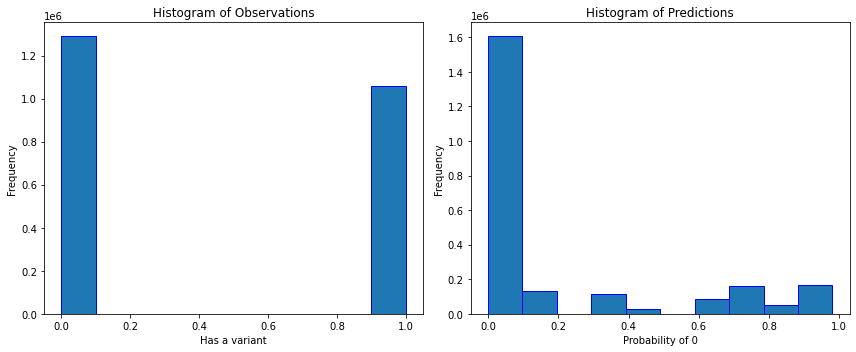

In [23]:
def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
plot_hist_from_predictions(predictions_df)

In [24]:
# Add a constant term to the independent variable for the intercept
X = sm.add_constant(predictions_df['prob_0'])

# Fit the linear regression model
model2 = sm.OLS(predictions_df['observation'],X).fit()

model2.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

# Get the summary of the regression
print(model2.summary())

# Extract the F-statistic and its associated p-value
f_statistic = model2.fvalue
p_value_f_statistic = model2.f_pvalue

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 9.559e+05
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:15:01   Log-Likelihood:            -1.2913e+06
No. Observations:             2347387   AIC:                         2.583e+06
Df Residuals:                 2347385   BIC:                         2.583e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6169      0.000   1914.188      0.0

## Visualize predictions for specific genes

In [25]:
# Filter for the positions with probability > 0.6 of observing a 0
pos_over_60 = predictions_df[predictions_df['prob_0'] > 0.6]['pos'].to_numpy()

# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

# Calculate the proportion of each gene with probability > 0.6 of observing a 0
chr2_gene_df['proportion_over_60'] = chr2_gene_df.apply(lambda row: calculate_overlap(row, pos_over_60), axis=1)

# Display the result
chr2_gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,proportion_over_60
193059,chr2,HAVANA,CDS,45440,46385,.,-,0,ENSG00000184731.6,protein_coding,FAM110C,ENST00000327669.5,ENST00000327669,5,FAM110C-201,0.031712
193062,chr2,HAVANA,CDS,41611,41627,.,-,2,ENSG00000184731.6,protein_coding,FAM110C,ENST00000327669.5,ENST00000327669,5,FAM110C-201,0.000000
193079,chr2,HAVANA,CDS,263984,263984,.,-,0,ENSG00000035115.22,protein_coding,SH3YL1,ENST00000403712.6,ENST00000403712,6,SH3YL1-205,0.000000
193083,chr2,HAVANA,CDS,253005,253115,.,-,2,ENSG00000035115.22,protein_coding,SH3YL1,ENST00000403712.6,ENST00000403712,6,SH3YL1-205,0.252252
193085,chr2,HAVANA,CDS,249731,249844,.,-,2,ENSG00000035115.22,protein_coding,SH3YL1,ENST00000403712.6,ENST00000403712,6,SH3YL1-205,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341845,chr2,HAVANA,CDS,241894216,241894339,.,-,1,ENSG00000216921.9,protein_coding,FAM240C,ENST00000404031.6,ENST00000404031,6,FAM240C-202,0.104839
341852,chr2,HAVANA,CDS,241897186,241897331,.,-,0,ENSG00000216921.9,protein_coding,FAM240C,ENST00000452112.5,ENST00000452112,5,FAM240C-203,0.020548
341855,chr2,HAVANA,CDS,241894216,241894339,.,-,1,ENSG00000216921.9,protein_coding,FAM240C,ENST00000452112.5,ENST00000452112,5,FAM240C-203,0.104839
341863,chr2,HAVANA,CDS,241897186,241897331,.,-,0,ENSG00000216921.9,protein_coding,FAM240C,ENST00000401641.2,ENST00000401641,2,FAM240C-201,0.020548


In [26]:
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

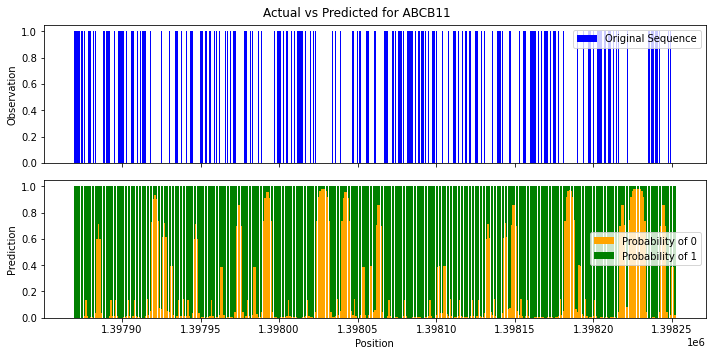

In [27]:
# print(np.where(predictions_df['pos'] == min(gene_df[(gene_df['gene_name'] == "HAT1") ]['start'])))

start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == "ABCB11") ]['start']))[0][0] + 750
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == "ABCB11")]['end']))[0][0] - 2800

plot_subsequence_predictions(start_idx, end_idx, name="ABCB11")

# plt.hist(probabilities[start_idx:end_idx, 0])
# plt.show()

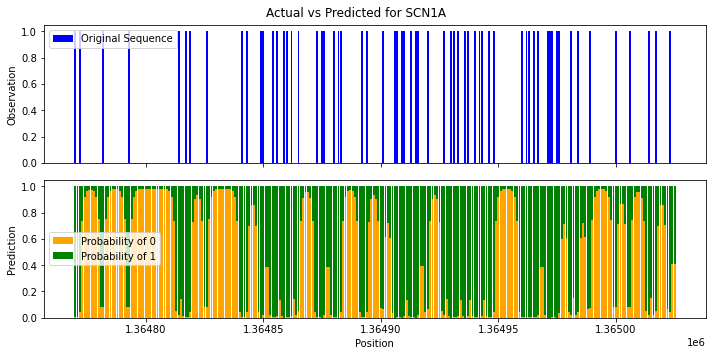

In [28]:
start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == "SCN1A") & (chr2_gene_df['start'].isin(pos_over_60))]['start']))[0][0] + 750
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == "SCN1A") & (chr2_gene_df['end'].isin(pos_over_60))]['end']))[0][0] - 2800 

plot_subsequence_predictions(start_idx, end_idx, name="SCN1A")

## Read protein domains information and summarize across genes


In [31]:
gene_name = "SCN1A"

# Retrieve the gencodeId from your gene_df DataFrame
for i in range(21):
    gencode_id = chr2_gene_df[chr2_gene_df['gene_name'] == gene_name]['gene_id'].iloc[0].split('.')[0] + "."  + str(i)
    
    # GTEx API endpoint for gene expression
    api_url = "https://gtexportal.org/api/v2/expression/medianGeneExpression"

    # Make the API request
    response = requests.get(api_url, params={"gencodeId": gencode_id})

    # Check if the response is successful and the DataFrame is not empty
    if response.status_code == 200 and not pd.DataFrame(response.json()['data']).empty:
        # If DataFrame is not empty, break the loop
        break

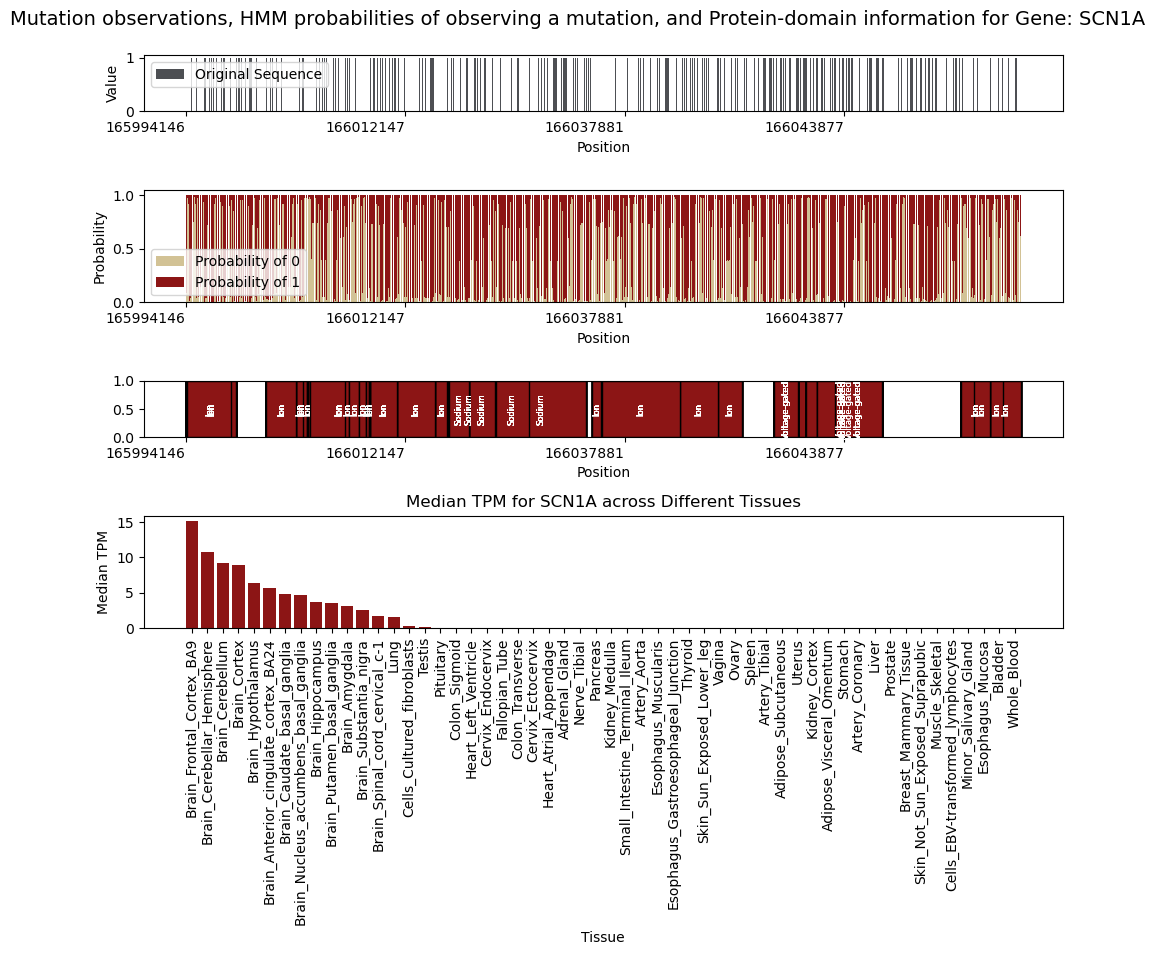

In [35]:
# Reset matplotlib to default, then customize
mpl.rcdefaults()

# Stanford Cardinal inspired color palette
stanford_palette = ['#8C1515', '#D2C295', '#000000', '#4D4F53']  # Cardinal Red, Sandstone, Black, Grey
contrast_blue = '#005AB5'  # A contrasting blue color

# Check if the response is successful
if response.status_code == 200:
    # Load the data into a pandas DataFrame
    expression_data = pd.DataFrame(response.json()['data'])
    # Calculate the median TPM for each tissue
    median_tpm = expression_data.groupby('tissueSiteDetailId')['median'].median().sort_values(ascending=False)
else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")

# Create the title string
title = f"Mutation observations, HMM probabilities of observing a mutation, and Protein-domain information for Gene: {gene_name}"

# Adjust the start and end indices based on your specific conditions
start_idx = np.where(predictions_df['pos'] == min(chr2_gene_df[(chr2_gene_df['gene_name'] == gene_name) & (chr2_gene_df['start'].isin(pos_over_60))]['start']))[0][0]
end_idx = np.where(predictions_df['pos'] == max(chr2_gene_df[(chr2_gene_df['gene_name'] == gene_name) & (chr2_gene_df['end'].isin(pos_over_60))]['end']))[0][0]

# Filter gene_domain_df to include only rows overlapping with start_idx and end_idx
overlapping_domains = gene_domain_df[(gene_domain_df['start'] >= predictions_df['pos'][start_idx]) & (gene_domain_df['end'] <= predictions_df['pos'][end_idx])]

# Adjust the subplots to include the fourth plot
fig, axs = plt.subplots(4, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 2, 1, 2]})

#axs[0].bar(predictions_df['pos'][start_idx:end_idx], observations[start_idx:end_idx], color='blue', label='Original Sequence')
axs[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color=stanford_palette[3], label='Original Sequence')

axs[0].set(xlabel='Position', ylabel='Value')
axs[0].legend()

# Plot the predicted probabilities as stacked barplots
axs[1].bar(range(start_idx,end_idx), probabilities[start_idx:end_idx, 0], color=stanford_palette[1], label='Probability of 0')
axs[1].bar(range(start_idx,end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color=stanford_palette[0], label='Probability of 1')

axs[1].set(xlabel='Position', ylabel='Probability')
axs[1].legend()

# Set sparse x-axis labels for axs[0] and axs[1]
sparse_ticks = np.arange(start_idx, end_idx, step=1000)  # Adjust the step value as needed
axs[0].set_xticks(sparse_ticks)
axs[0].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')
axs[1].set_xticks(sparse_ticks)
axs[1].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')


# Convert 'pos' column to numeric type
predictions_df['pos'] = pd.to_numeric(predictions_df['pos'], errors='coerce')

# Get x-axis limits of axs[1]
x_limits = axs[1].get_xlim()

# Set x-axis limits for axs[2]
axs[2].set_xlim(x_limits)

# Add a horizontal rectangle for each overlapping domain to the bottom plot
for _, domain_row in overlapping_domains.iterrows():
    rect_start = np.where((predictions_df['pos'] >=  domain_row['start']) & (predictions_df['pos'] <=  domain_row['end']))
    if len(rect_start[0]) == 0:
        continue
    rect_start = min(rect_start[0])
    rect_end = max(np.where((predictions_df['pos'] >=  domain_row['start']) & (predictions_df['pos'] <=  domain_row['end']))[0])
    rect_width = rect_end - rect_start
    rect_height = 1
    rect = Rectangle((rect_start, 0), rect_width, rect_height, linewidth=1, edgecolor="black", facecolor=stanford_palette[0], label=domain_row['domain_name'])
    axs[2].add_patch(rect)
    # Annotate with smaller font size and 90-degree rotation
    axs[2].annotate(
        domain_row['domain_name'],
        xy=(rect_start + rect_width / 2, 0.5),
        color='white',
        ha='center',
        va='center',
        fontsize=6,  # Set the font size
        rotation=90,  # Rotate text by 90 degrees
    )
axs[2].set(xlabel='Position')
axs[2].set_xticks(sparse_ticks)
axs[2].set_xticklabels(predictions_df['pos'][sparse_ticks],  ha='right')


# Plot the GTEx tissue expression profile
axs[3].bar(median_tpm.index, median_tpm.values, color=stanford_palette[0])
axs[3].set(xlabel='Tissue', ylabel='Median TPM')
axs[3].tick_params(axis='x', rotation=90)  # Rotate tissue names for readability
axs[3].set_title("Median TPM for " + gene_name + " across Different Tissues")

# Add the title
plt.suptitle(title, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
# Calculate the proportion of each gene-domain combination with probability > 0.6 of observing a 0
gene_domain_df['gene_domain_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60), axis=1)

# Calculate the proportion of each gene with probability > 0.6 of observing a 0
gene_domain_df['gene_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60, start_col='gene_start', end_col='gene_end'), axis=1)

# Calculate the proportion of each domain with probability > 0.6 of observing a 0
gene_domain_df['domain_proportion_over_60'] = gene_domain_df.apply(lambda row: calculate_overlap(row, pos_over_60, start_col='domain_start', end_col='domain_end'), axis=1)

# Derive length column
gene_domain_df['length'] = abs(gene_domain_df['end'] - gene_domain_df['start']) + 1
chr2_gene_df['length'] = abs(chr2_gene_df['end'] - chr2_gene_df['start']) + 1

# Display the result in different subsets
# gene_domain_df[(gene_domain_df['gene_domain_proportion_over_60'] > .4) & (gene_domain_df['gene_proportion_over_60'] < .2) & (gene_domain_df['length'] > 20)]
# gene_df[gene_df['proportion_over_80'] > .5]['gene_name'].unique()
# chr2_gene_df[chr2_gene_df['proportion_over_60'] > 0.5].sort_values(by='proportion_over_60', ascending=False)
# chr2_gene_df[(chr2_gene_df['proportion_over_60'] > 0.5) & (chr2_gene_df['length'] > 50)]['gene_name'].unique()
# chr2_gene_df[(chr2_gene_df['proportion_over_60'] > 0.5) & (chr2_gene_df['length'] > 50)].sort_values(by='proportion_over_60', ascending=False)

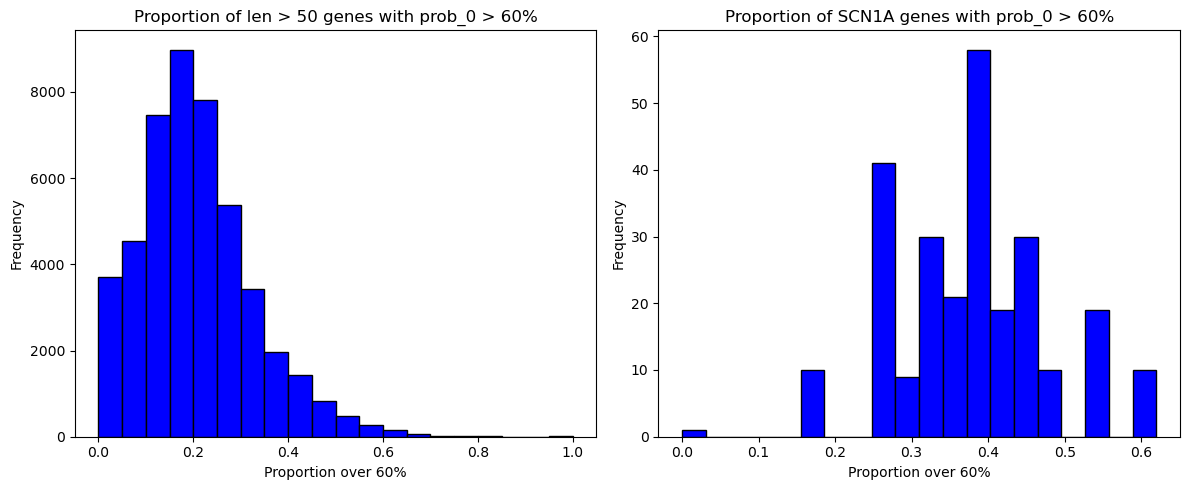

In [39]:
filtered_df = chr2_gene_df[(chr2_gene_df['length'] > 50)]
filtered_df_scn1a = chr2_gene_df[(chr2_gene_df['gene_name'].str.upper() == "SCN1A")]

# Create a figure with two subplots in one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram in the first subplot
axs[0].hist(filtered_df['proportion_over_60'], bins=20, color='blue', edgecolor='black')
axs[0].set_title('Proportion of len > 50 genes with prob_0 > 60%')
axs[0].set_xlabel('Proportion over 60%')
axs[0].set_ylabel('Frequency')

# Plot the second histogram in the second subplot
axs[1].hist(filtered_df_scn1a['proportion_over_60'], bins=20, color='blue', edgecolor='black')
axs[1].set_title('Proportion of SCN1A genes with prob_0 > 60%')
axs[1].set_xlabel('Proportion over 60%')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

## Compare results with Alpha Missense and Epi25

In [25]:
# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()
chr2_alpha_missense_df = alpha_missense_grouped_df[alpha_missense_grouped_df['chr'] == 'chr2']

epi25_variants_chr2_df = epi25_variant_results_df[epi25_variant_results_df['chr'] == "chr2"].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "variant_id", "estimate", "chi_sq_stat", "in_analysis", "chr"])

merged_df = pd.merge(pd.merge(predictions_df, chr2_alpha_missense_df, on='pos', how='inner'), epi25_variants_chr2_df, on='pos', how='inner')

merged_df = merged_df[(merged_df['ac_case'] > 0) & (merged_df['ac_ctrl'] > 0)]

# Calculating odds and log odds ratio
merged_df['odds_case'] = merged_df['ac_case'] / (merged_df['an_case'] - merged_df['ac_case'])
merged_df['odds_ctrl'] = merged_df['ac_ctrl'] / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])
merged_df['effect_size'] = np.log(merged_df['odds_case'] / merged_df['odds_ctrl'])

# Calculating the variance of log odds ratio
merged_df['var_effect_size'] = 1 / merged_df['ac_case'] + 1 / (merged_df['an_case'] - merged_df['ac_case']) + 1 / merged_df['ac_ctrl'] + 1 / (merged_df['an_ctrl'] - merged_df['ac_ctrl'])

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_epi25_chr2_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,pos,prob_0,prob_1,observation,chr,am_pathogenicity,gene_id,consequence,group,ac_case,an_case,ac_ctrl,an_ctrl,p_value,odds_case,odds_ctrl,effect_size,var_effect_size
0,41612,0.000041,0.999959,1.0,chr2,0.1313,ENSG00000184731,other_missense,DEE,1,3874,4,66836,NaN,0.000258,0.000060,1.461858,1.250273
1,41612,0.000041,0.999959,1.0,chr2,0.1313,ENSG00000184731,other_missense,EPI,1,41920,4,66836,NaN,0.000024,0.000060,-0.919852,1.250039
5,41613,0.000041,0.999959,1.0,chr2,0.0848,ENSG00000184731,pLoF,EPI,2,41906,2,66816,NaN,0.000048,0.000030,0.466531,1.000039
7,41613,0.000041,0.999959,1.0,chr2,0.0848,ENSG00000184731,pLoF,NAFE,2,18428,2,66816,NaN,0.000109,0.000030,1.288150,1.000069
9,41620,0.009943,0.990057,1.0,chr2,0.2398,ENSG00000184731,other_missense,EPI,1,41910,2,66844,NaN,0.000024,0.000030,-0.226316,1.500039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809412,241873188,0.002536,0.997464,1.0,chr2,0.7384,ENSG00000188011,damaging_missense,EPI,1,41958,2,66888,NaN,0.000024,0.000030,-0.226803,1.500039
809413,241873188,0.002536,0.997464,1.0,chr2,0.7384,ENSG00000188011,damaging_missense,GGE,1,10998,2,66888,NaN,0.000091,0.000030,1.112220,1.500106
809430,241873240,0.002616,0.997384,1.0,chr2,0.7266,ENSG00000188011,other_missense,EPI,3,41956,5,66770,NaN,0.000072,0.000075,-0.046197,0.533372
809431,241873240,0.002616,0.997384,1.0,chr2,0.7266,ENSG00000188011,other_missense,GGE,2,10996,5,66770,NaN,0.000182,0.000075,0.887539,0.700106


In [70]:
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

In [52]:
# Read the data from the file
data = pd.read_csv(project_path + "constraint_am_epi25_chr2_results.tsv.gz", sep='\t')

# Get unique values in the 'gene_id' column
unique_genes = data['gene_id'].unique()

# Initialize lists to store p-values
p_values_prob_0 = []
p_values_am_pathogenicity = []

# Loop over each gene and build a meta-regression model
for current_gene in unique_genes:
    # Subset the data for the current gene
    gene_data = data[data['gene_id'] == current_gene]
    
    # Check if there are at least 2 unique values in the dependent variable
    try:
        # Meta-regression model for the current gene
        X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
        y = np.log(gene_data['effect_size'])
        weights = 1 / np.sqrt(gene_data['var_effect_size'])  # Assuming the weights are based on the square root of var_effect_size

        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Get p-values for prob_0 and am_pathogenicity
        p_value_prob_0 = model.pvalues['prob_0']
        p_value_am_pathogenicity = model.pvalues['am_pathogenicity']

        # Append p-values to lists
        p_values_prob_0.append(p_value_prob_0)
        p_values_am_pathogenicity.append(p_value_am_pathogenicity)
        
    except:
        pass

# Combine p-values using Fisher's method
fisher_combined_p_prob_0 = fisher_method_p_value(np.array(p_values_prob_0))
fisher_combined_p_am_pathogenicity = fisher_method_p_value(np.array(p_values_am_pathogenicity))

# Print combined p-values
print(f"Combined p-value for prob_0: {fisher_combined_p_prob_0}")
print(f"Combined p-value for am_pathogenicity: {fisher_combined_p_am_pathogenicity}")

Combined p-value for prob_0: 0.0
Combined p-value for am_pathogenicity: 0.0


#  Apply HMM to other chromosomes and analyze epilepsy, autism, schizophrenia, and bipolar

## Define helper functions

In [43]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(gene_df, coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(gene_df['end'].max(), coverage_df['pos'].max(), variants_df['pos'].max())

    # Create a boolean mask for the combined protein-coding regions
    protein_coding_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to set True for positions between 'start' and 'end' of the region
    for start, end in zip(gene_df['start'].to_numpy(), gene_df['end'].to_numpy()):
        protein_coding_mask[start:end+1] = 1

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[protein_coding_mask & coverage_mask])
    
    positions = np.where(protein_coding_mask & coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def fit_and_predict_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

In [44]:
def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()
    
def plot_subsequence_predictions(start_idx, end_idx, name='Target Region'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), sharex=True)
    plt.suptitle("Actual vs Predicted for " + name)

    # Plot the original sequence
    axes[0].bar(range(start_idx, end_idx), observations[start_idx:end_idx], color='blue', label='Original Sequence')
    axes[0].set_ylabel('Observation')
    axes[0].legend()

    # Plot the predicted probabilities as stacked barplots
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 0], color='orange', label='Probability of 0')
    axes[1].bar(range(start_idx, end_idx), probabilities[start_idx:end_idx, 1], bottom=probabilities[start_idx:end_idx, 0], color='green', label='Probability of 1')
    axes[1].set_xlabel('Position')
    axes[1].set_ylabel('Prediction')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
def plot_group_QQ(significance_df):
    # Get unique groups
    unique_groups = significance_df['group'].unique()

    # Number of unique groups
    num_groups = len(unique_groups)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_groups, 1, figsize=(8, 4 * num_groups))

    # Loop over each group and create a Q-Q plot
    for i, group in enumerate(unique_groups):
        # Filter the DataFrame for the current group
        group_df = significance_df[significance_df['group'] == group]

        # Calculate -log10(p-values)
        group_df['minus_log_pvalue'] = -np.log10(group_df['p_value'])

        # Sort by p-value in ascending order
        group_df = group_df.sort_values('p_value', ascending=True)

        # Calculate theoretical quantiles
        theoretical_quantiles = stats.norm.ppf((np.arange(1, len(group_df) + 1) / (len(group_df) + 1)))

        # Transform theoretical quantiles into -log10(p-values)
        group_df['theoretical_quantiles'] = -np.log10(stats.norm.cdf(theoretical_quantiles))

        # Plotting the Q-Q plot for the group
        ax = axs[i] if num_groups > 1 else axs
        ax.scatter(group_df['theoretical_quantiles'], group_df['minus_log_pvalue'], label=f'Observed -log10(p-value) for group {group}')

        # Define x for the expected line and confidence intervals
        x = np.linspace(min(group_df['theoretical_quantiles']), max(group_df['theoretical_quantiles']), 100)
        y = x
        ax.plot(x, y, color='r', ls='--', label='Expected -log10(p-value)')
        ax.fill_between(x, y - 1.96*np.sqrt((1-x)*x/len(group_df)), y + 1.96*np.sqrt((1-x)*x/len(group_df)), color='r', alpha=0.2)

        # Labeling significant genes
        significant_genes = group_df[group_df['p_value'] < .0001]
        for idx, row in significant_genes.iterrows():
            ax.text(row['theoretical_quantiles'], row['minus_log_pvalue'], row['gene_name'], fontsize=6)

        # Labeling the plot
        ax.set_xlabel('Expected -log10(p-value)')
        ax.set_ylabel('Observed -log10(p-value)')
        ax.set_title(f'Q-Q Plot of Gene P-Values for Group {group}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

## Get constraint predictions over the full genome

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1


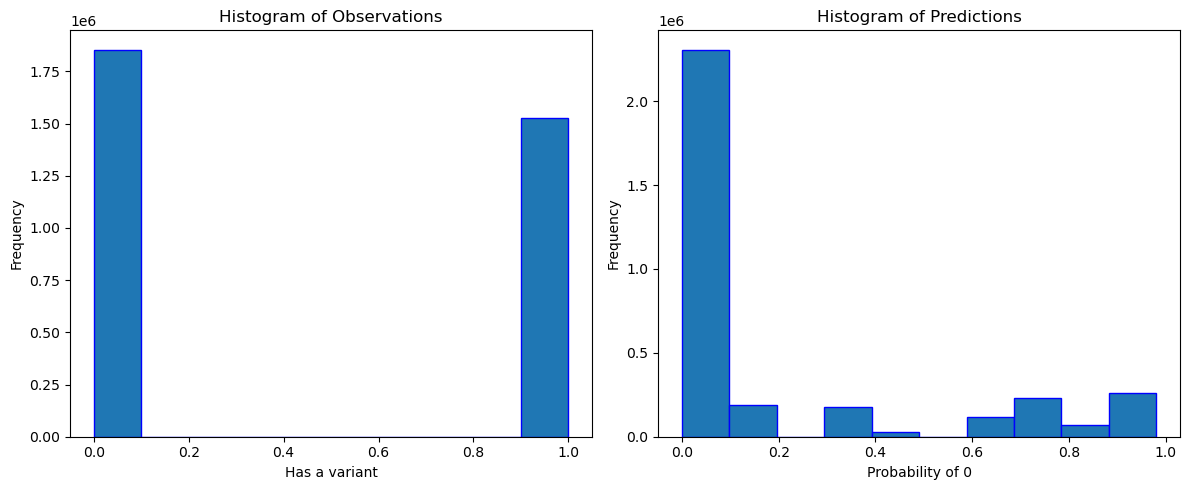

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 1.400e+06
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:23   Log-Likelihood:            -1.8517e+06
No. Observations:             3380119   AIC:                         3.703e+06
Df Residuals:                 3380117   BIC:                         3.703e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6192      0.000   2309.558      0.0

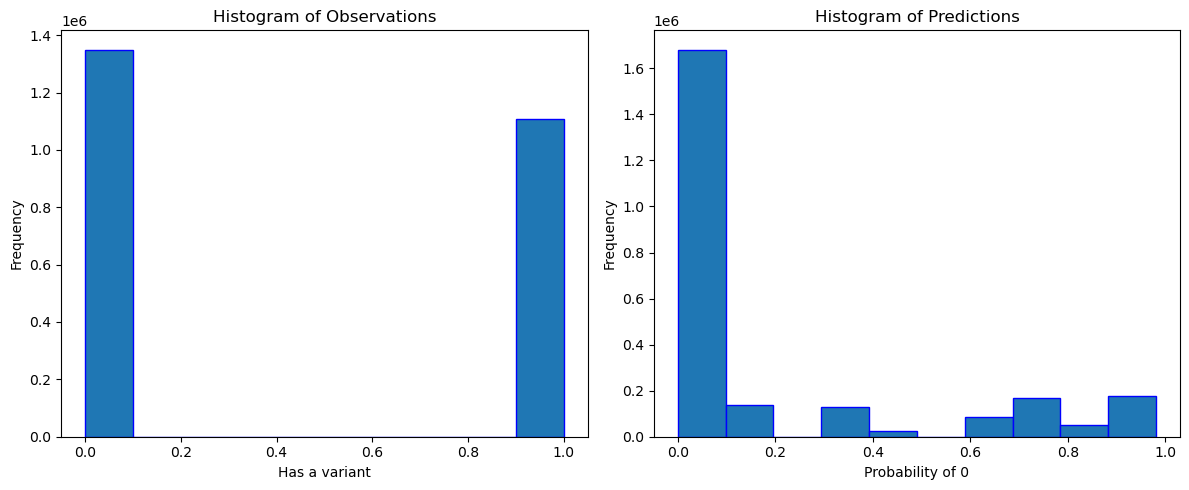

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 1.002e+06
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:41   Log-Likelihood:            -1.3518e+06
No. Observations:             2457680   AIC:                         2.704e+06
Df Residuals:                 2457678   BIC:                         2.704e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6171      0.000   1959.954      0.0

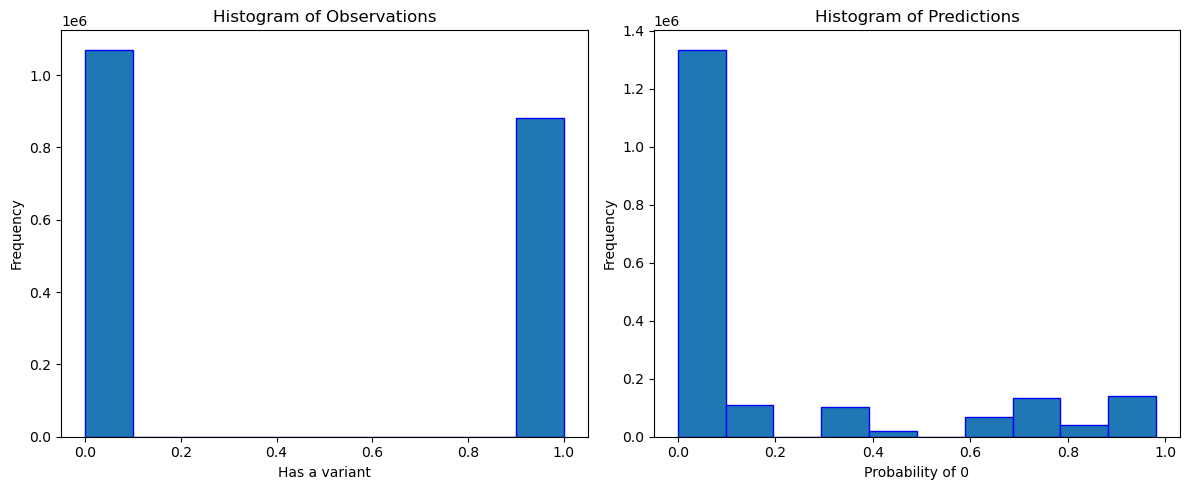

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 7.942e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:59:57   Log-Likelihood:            -1.0734e+06
No. Observations:             1950694   AIC:                         2.147e+06
Df Residuals:                 1950692   BIC:                         2.147e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6173      0.000   1746.676      0.0

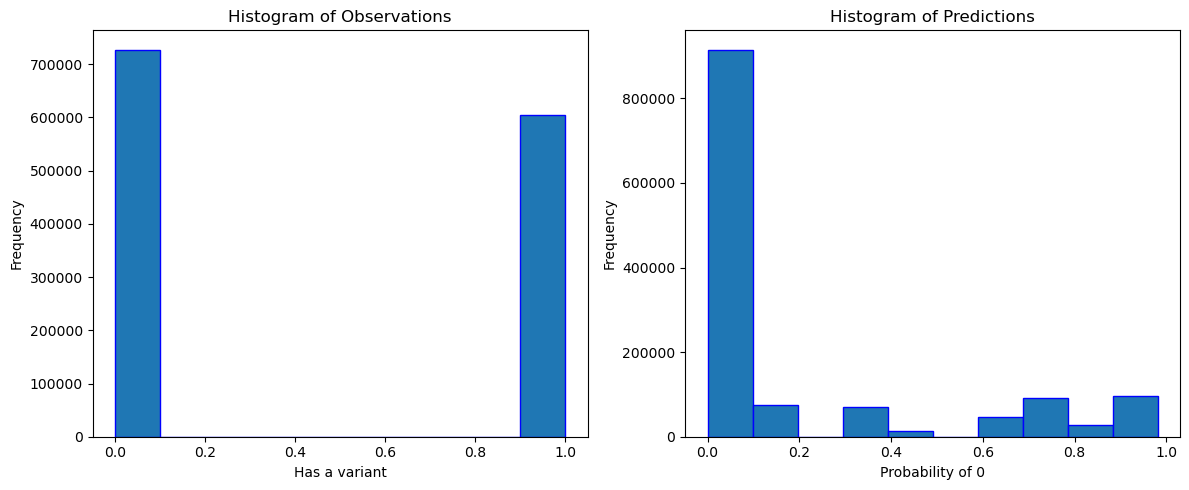

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 5.408e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:12   Log-Likelihood:            -7.3390e+05
No. Observations:             1331683   AIC:                         1.468e+06
Df Residuals:                 1331681   BIC:                         1.468e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6187      0.000   1447.884      0.0

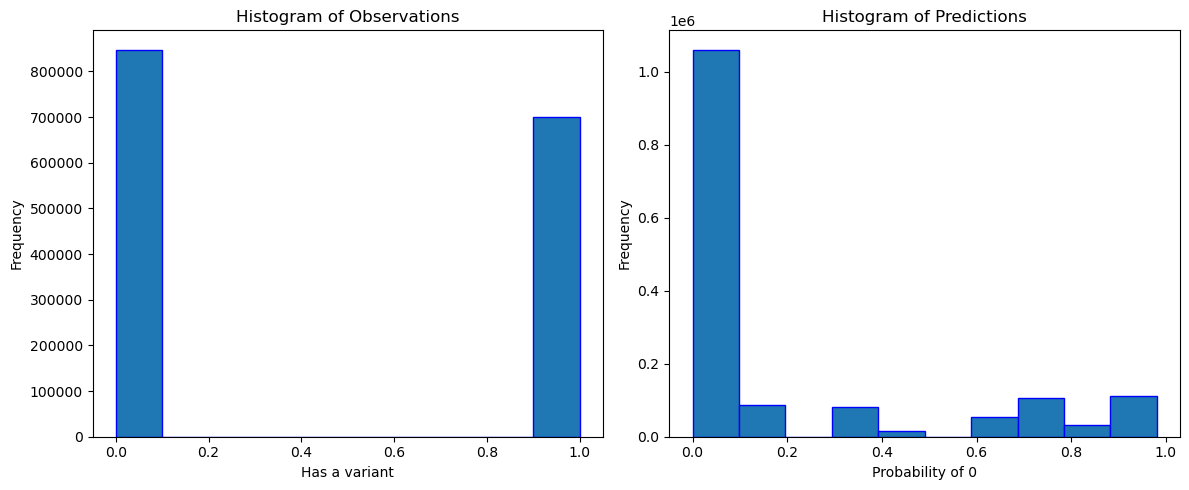

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 6.319e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:27   Log-Likelihood:            -8.5181e+05
No. Observations:             1548359   AIC:                         1.704e+06
Df Residuals:                 1548357   BIC:                         1.704e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6183      0.000   1559.818      0.0

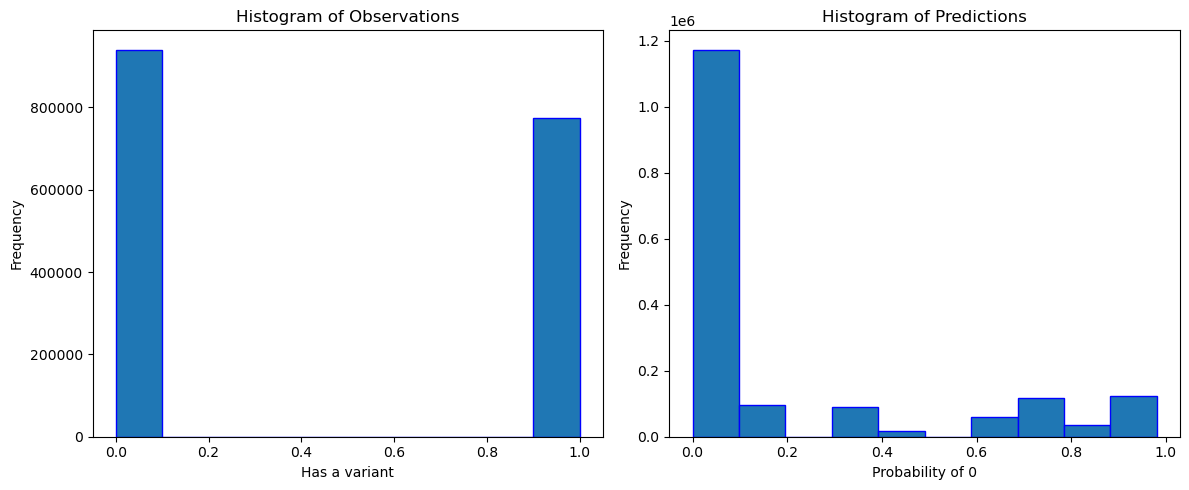

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.021e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:42   Log-Likelihood:            -9.4223e+05
No. Observations:             1714677   AIC:                         1.884e+06
Df Residuals:                 1714675   BIC:                         1.884e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6182      0.000   1640.933      0.0

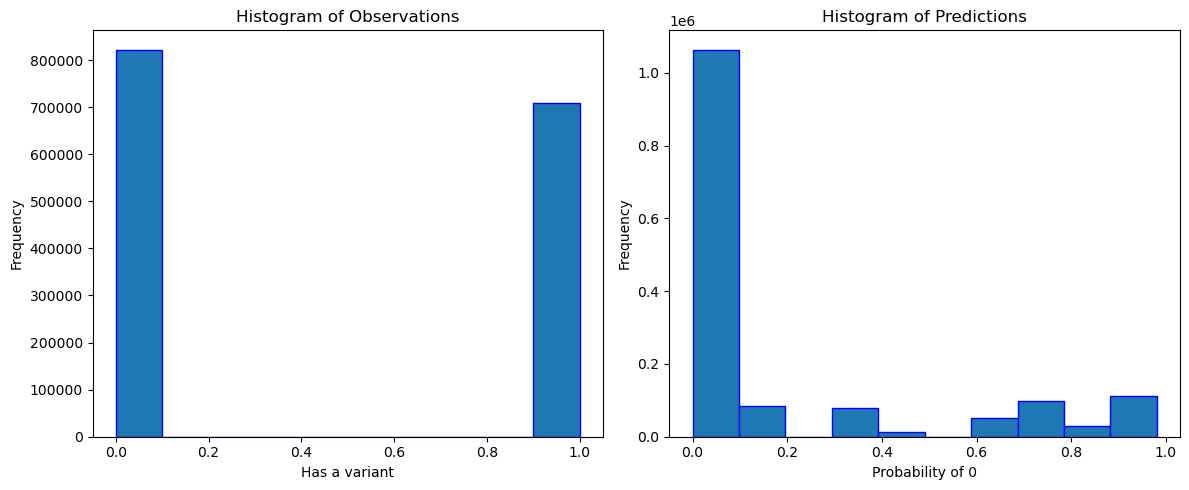

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 6.235e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:00:57   Log-Likelihood:            -8.4579e+05
No. Observations:             1531381   AIC:                         1.692e+06
Df Residuals:                 1531379   BIC:                         1.692e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6253      0.000   1575.601      0.0

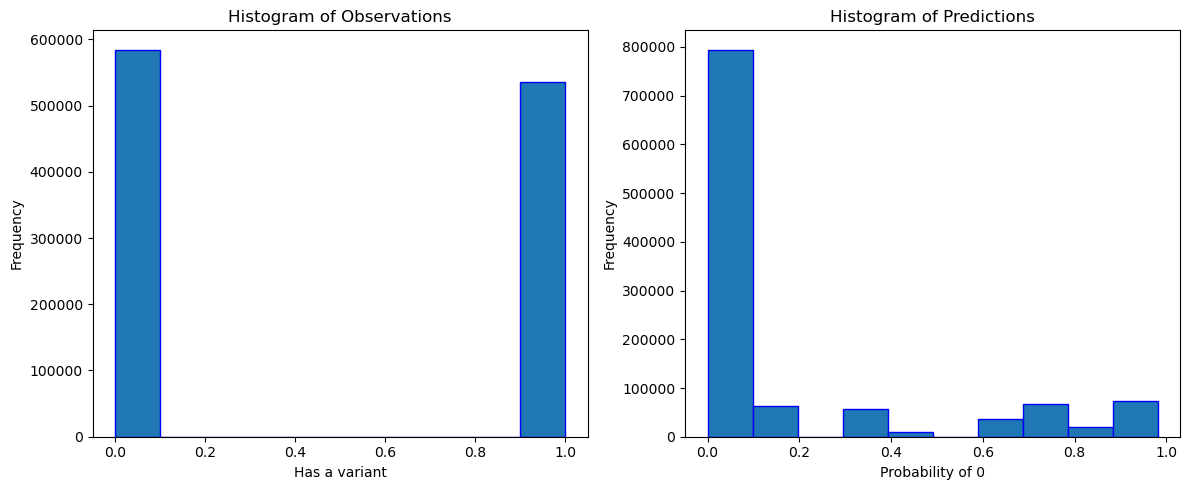

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                 4.456e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:13   Log-Likelihood:            -6.2414e+05
No. Observations:             1119857   AIC:                         1.248e+06
Df Residuals:                 1119855   BIC:                         1.248e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6331      0.000   1370.914      0.0

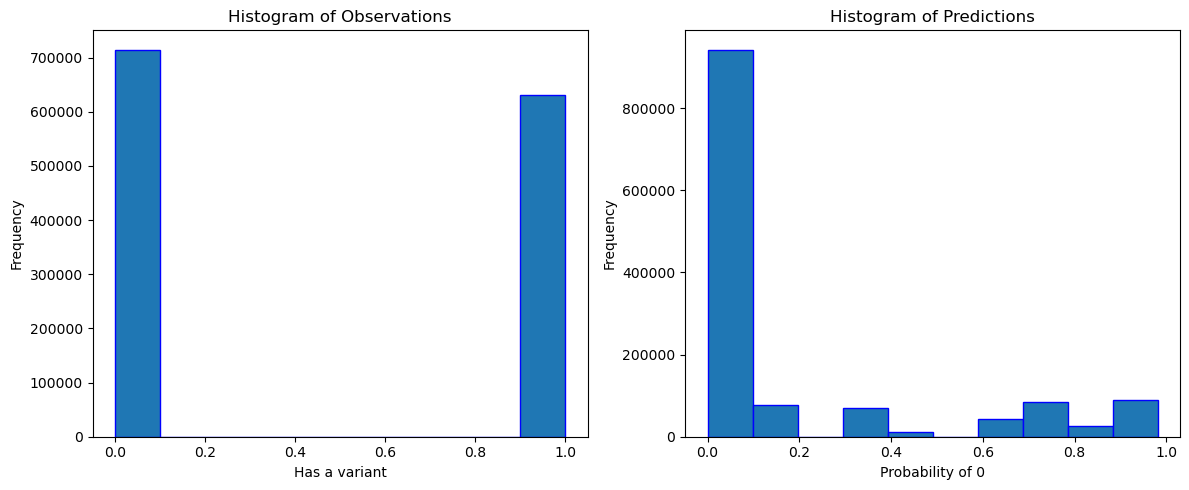

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                 5.370e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:29   Log-Likelihood:            -7.4730e+05
No. Observations:             1344526   AIC:                         1.495e+06
Df Residuals:                 1344524   BIC:                         1.495e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6269      0.000   1481.747      0.0

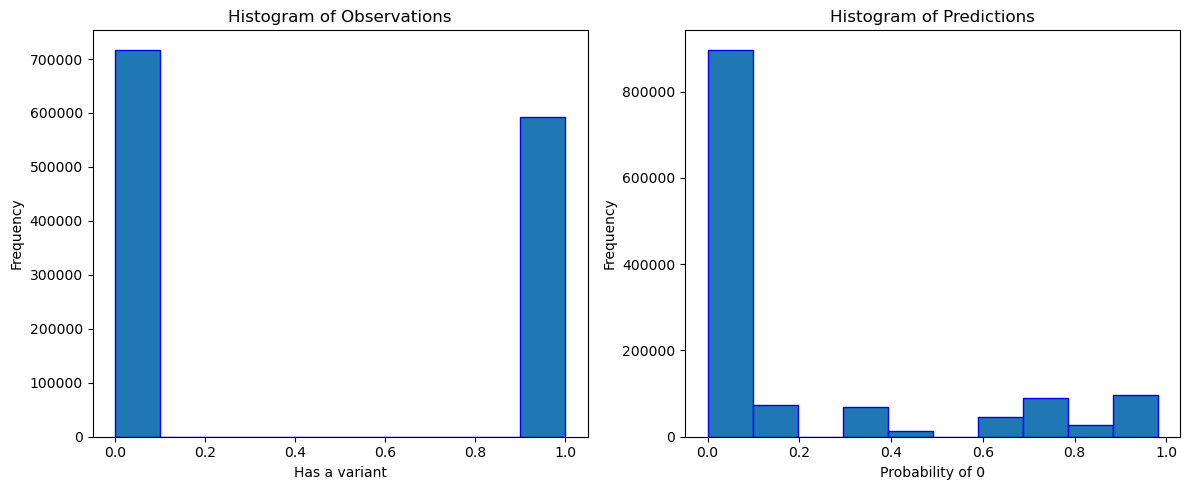

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 5.367e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:44   Log-Likelihood:            -7.2003e+05
No. Observations:             1310128   AIC:                         1.440e+06
Df Residuals:                 1310126   BIC:                         1.440e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6187      0.000   1436.125      0.0

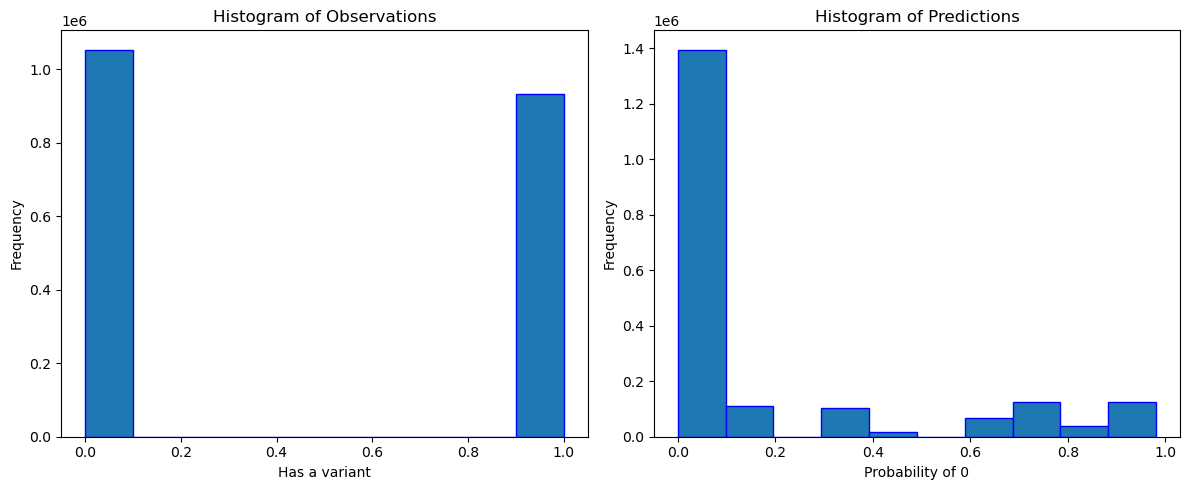

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 7.867e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:00   Log-Likelihood:            -1.1052e+06
No. Observations:             1984372   AIC:                         2.210e+06
Df Residuals:                 1984370   BIC:                         2.211e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6268      0.000   1799.580      0.0

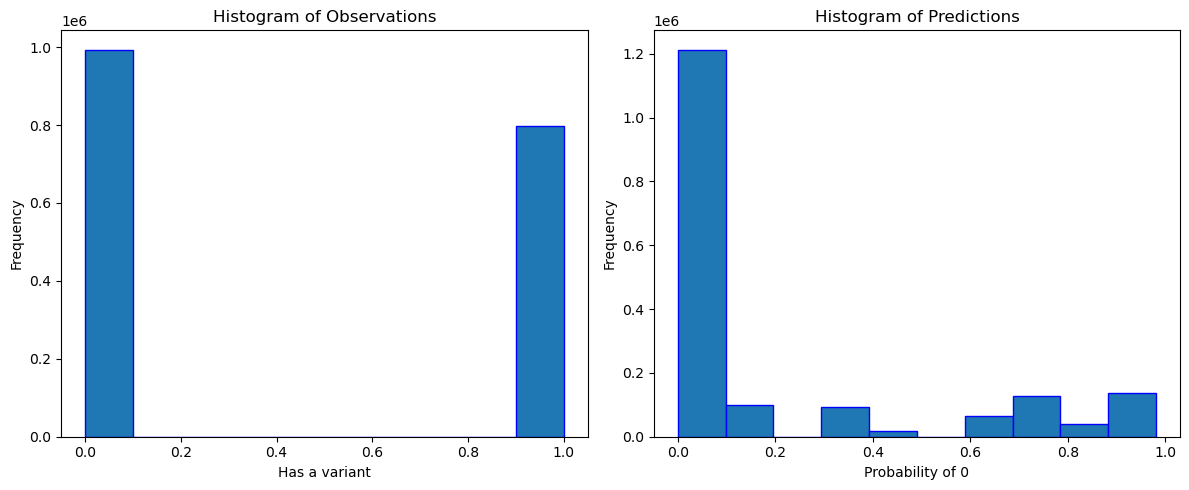

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                 7.430e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:15   Log-Likelihood:            -9.7841e+05
No. Observations:             1791120   AIC:                         1.957e+06
Df Residuals:                 1791118   BIC:                         1.957e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6152      0.000   1666.185      0.0

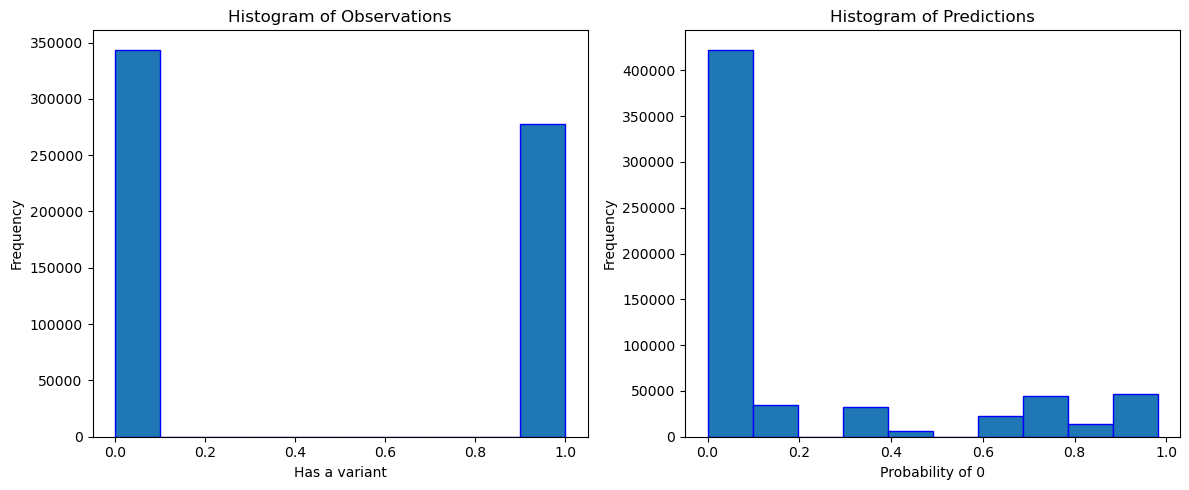

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 2.556e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:29   Log-Likelihood:            -3.4064e+05
No. Observations:              621634   AIC:                         6.813e+05
Df Residuals:                  621632   BIC:                         6.813e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6155      0.001    982.252      0.0

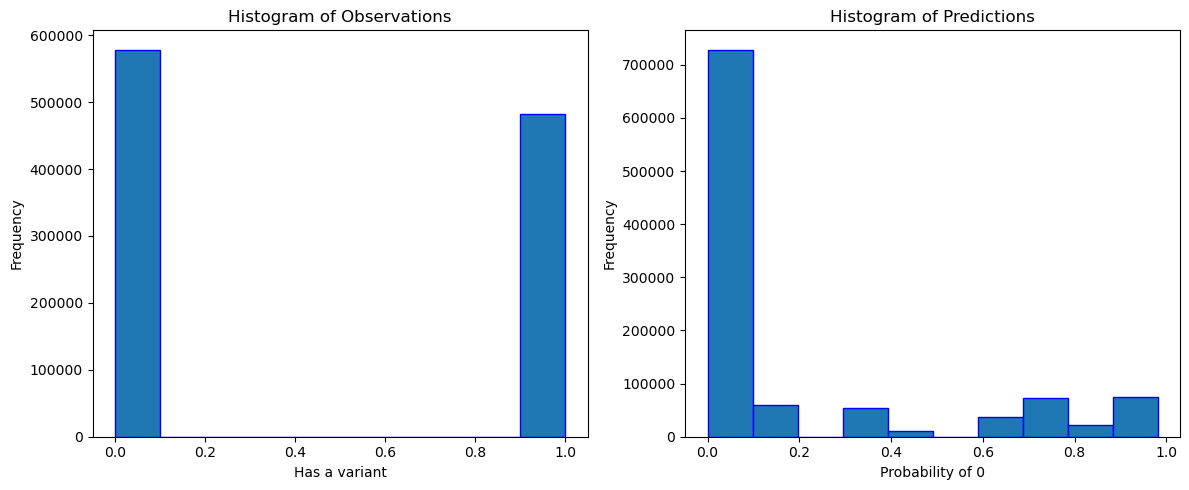

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 4.308e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:43   Log-Likelihood:            -5.8413e+05
No. Observations:             1059970   AIC:                         1.168e+06
Df Residuals:                 1059968   BIC:                         1.168e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6192      0.000   1292.966      0.0

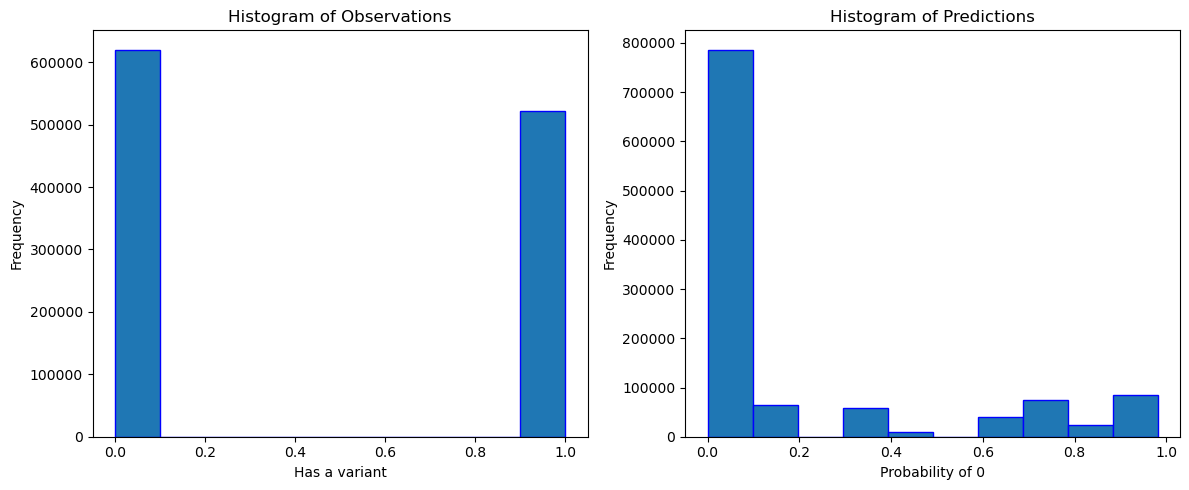

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 4.653e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:02:57   Log-Likelihood:            -6.2928e+05
No. Observations:             1141775   AIC:                         1.259e+06
Df Residuals:                 1141773   BIC:                         1.259e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6210      0.000   1347.804      0.0

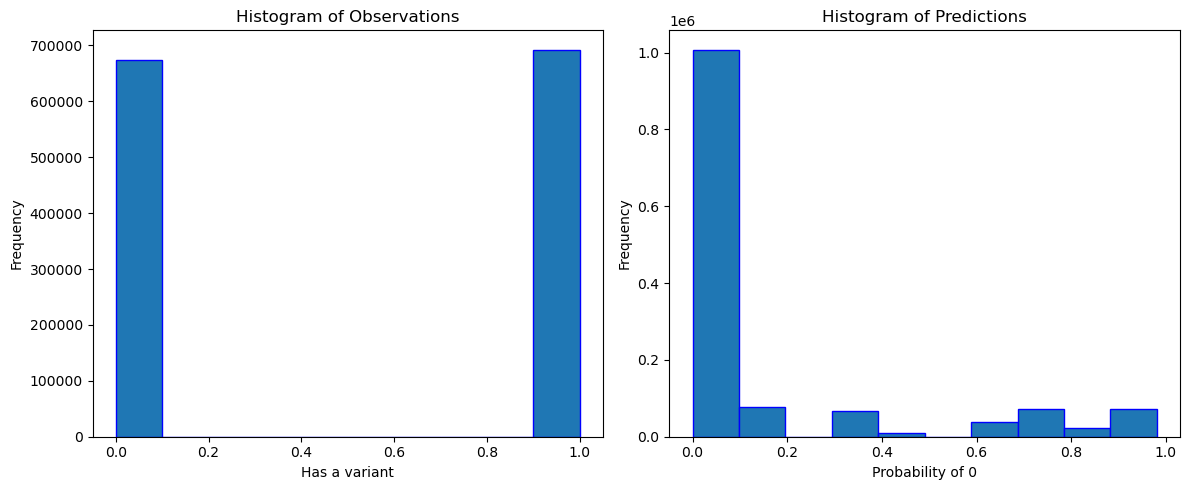

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                 5.181e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:13   Log-Likelihood:            -7.7218e+05
No. Observations:             1366699   AIC:                         1.544e+06
Df Residuals:                 1366697   BIC:                         1.544e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6481      0.000   1566.187      0.0

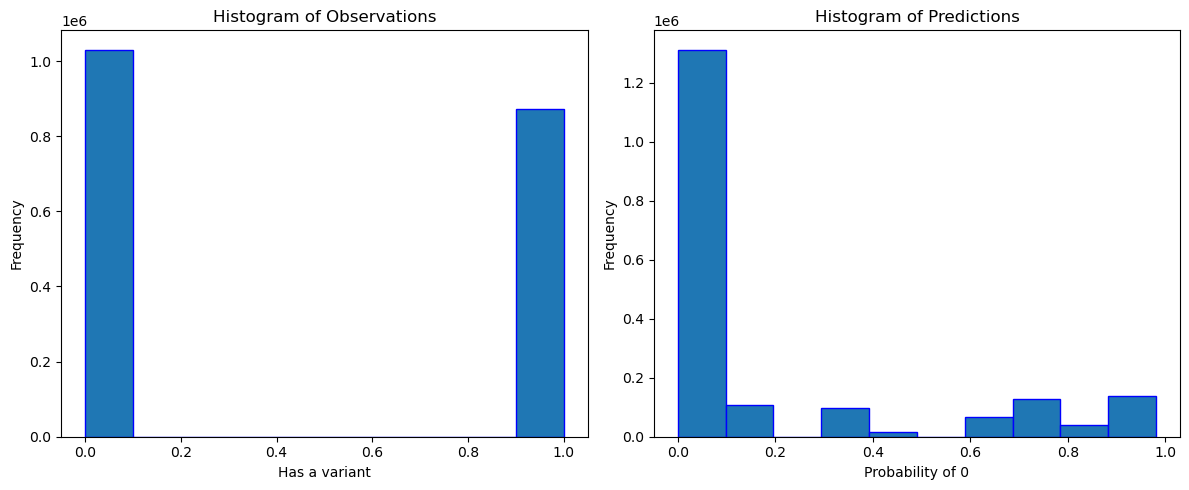

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                 7.788e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:30   Log-Likelihood:            -1.0472e+06
No. Observations:             1901748   AIC:                         2.094e+06
Df Residuals:                 1901746   BIC:                         2.094e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6226      0.000   1744.926      0.0

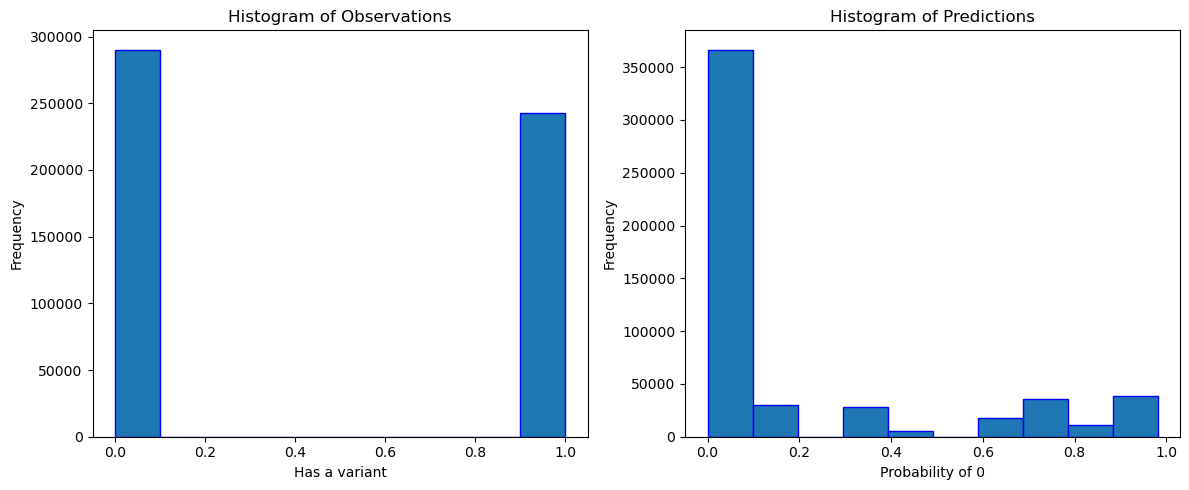

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 2.171e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:03:44   Log-Likelihood:            -2.9353e+05
No. Observations:              532825   AIC:                         5.871e+05
Df Residuals:                  532823   BIC:                         5.871e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6200      0.001    918.543      0.0

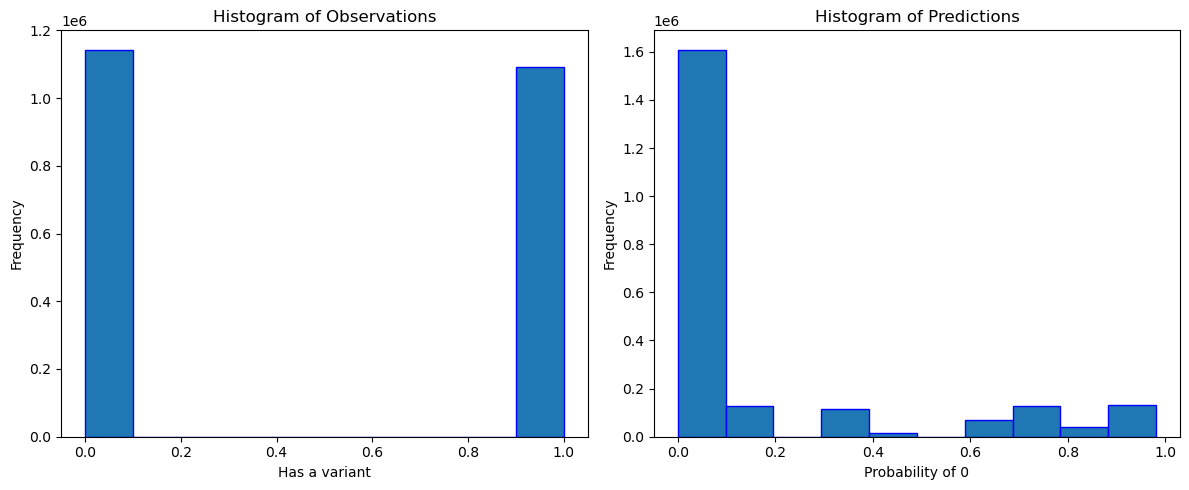

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                 8.685e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:01   Log-Likelihood:            -1.2543e+06
No. Observations:             2234481   AIC:                         2.509e+06
Df Residuals:                 2234479   BIC:                         2.509e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6379      0.000   1957.333      0.0

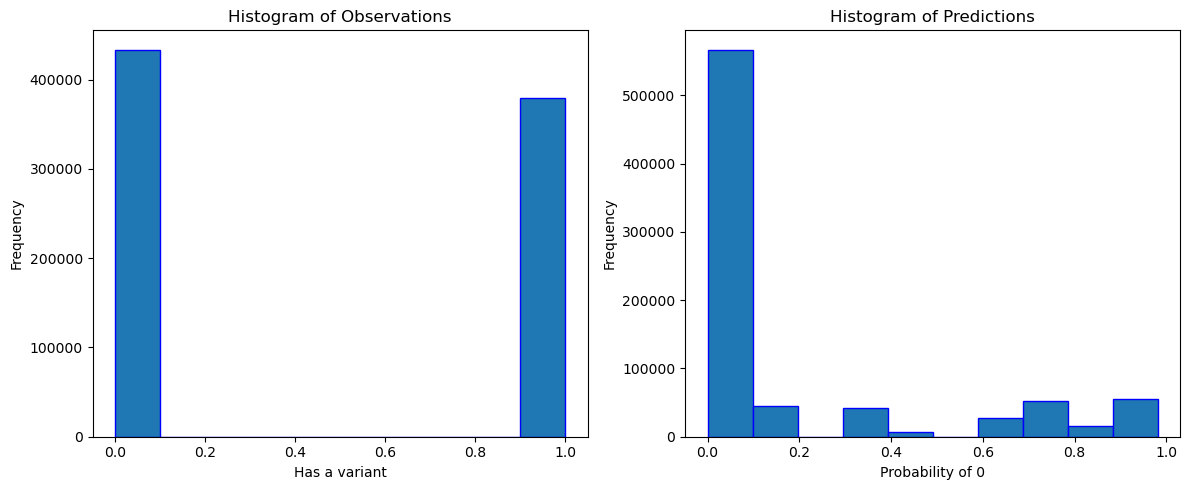

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 3.293e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:16   Log-Likelihood:            -4.4978e+05
No. Observations:              812688   AIC:                         8.996e+05
Df Residuals:                  812686   BIC:                         8.996e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6271      0.001   1152.104      0.0

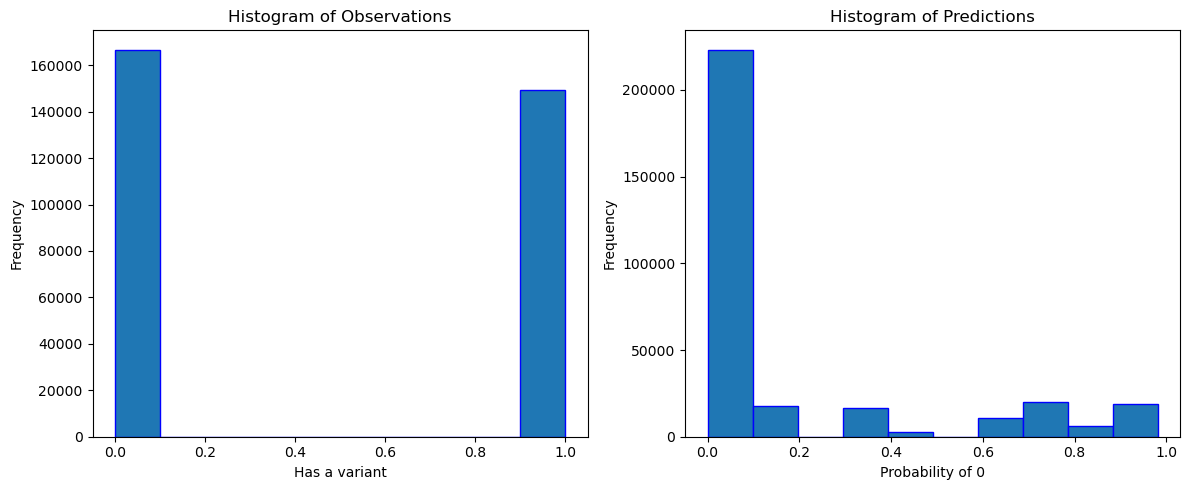

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:30   Log-Likelihood:            -1.7628e+05
No. Observations:              316182   AIC:                         3.526e+05
Df Residuals:                  316180   BIC:                         3.526e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6290      0.001    721.664      0.0

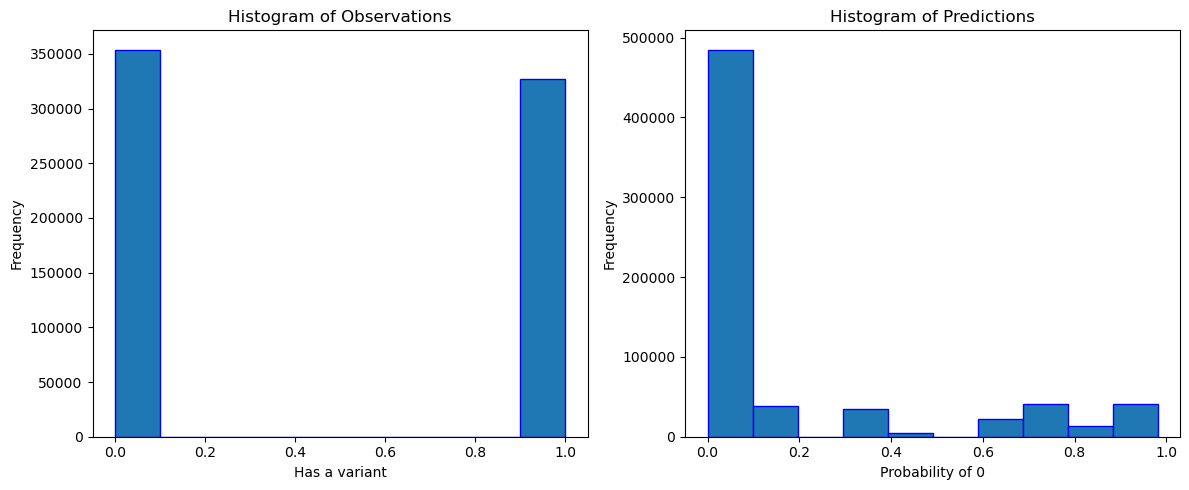

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 2.689e+05
Date:                Tue, 06 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:04:42   Log-Likelihood:            -3.8053e+05
No. Observations:              681114   AIC:                         7.611e+05
Df Residuals:                  681112   BIC:                         7.611e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6340      0.001   1071.141      0.0

,chr,pos,prob_0,prob_1,observation
0,chr1,69344,1.707209e-31,1.000000,0.0
1,chr1,69345,1.321818e-01,0.867818,0.0
2,chr1,69346,1.468097e-02,0.985319,0.0
3,chr1,69347,2.860514e-02,0.971395,1.0
4,chr1,69348,3.884401e-01,0.611560,0.0
...,...,...,...,...,...
32133707,chr22,50782288,2.463175e-02,0.975368,0.0
32133708,chr22,50782289,3.864468e-03,0.996136,1.0
32133709,chr22,50782290,2.528301e-03,0.997472,0.0
32133710,chr22,50782291,4.113130e-05,0.999959,1.0


In [31]:
# Parameters for analysis
coverage_thr = 0.5
order = 2

# Initialize empty dataframes
predictions_df = pd.DataFrame(columns=['chr', 'pos','prob_0', 'prob_1', 'observation'])

# Filter rows for chromosome 2
chr_gene_df = gene_df[gene_df['chr'] == 'chr2']
chr_variants_df = variants_df[variants_df['chr'] == 2]
chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr2') & (coverage_df['over_10'] > coverage_thr)]

# Get training data for the chromosome
observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

# Fit HMM to Chromosome 2
model = fit_HMM(observations, order=order)

for chromnum in range(1,23):
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_gene_df = gene_df[gene_df['chr'] == 'chr' + str(chromnum)]
    chr_variants_df = variants_df[variants_df['chr'] == chromnum]
    chr_coverage_df = coverage_df[(coverage_df['chr'] == 'chr' + str(chromnum)) & (coverage_df['over_10'] > coverage_thr)]
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_gene_df, chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Append predictions to overall df
    predictions_df = pd.concat([predictions_df, chr_predictions_df], ignore_index=True)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)

# Write predictions_df to a csv to avoid recomputing
predictions_df.to_csv(project_path + "HMM_wgs_constraint_predictions.tsv.gz", index=False, compression='gzip', sep='\t')

predictions_df

# ***Run these cells for Alpha Missense analysis***

In [5]:
# Helper functions

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
#     Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
#     print("SCN1A:", len(cases_df[cases_df['gene_name'] == 'SCN1A']))
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df

# Initialize the liftover object for hg19 to hg38
lo = LiftOver('hg19', 'hg38')

# Function to liftover a single row
def liftover(row):
    lifted = lo.convert_coordinate(row['chr'], row['pos'])
    if lifted:
        # Returns the first lifted coordinate (chromosome, position)
        return lifted[0][0], int(lifted[0][1])
    else:
        # Returns 0 if liftover fails
        return row['chr'], 0
    
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if any(np.isnan(p_values)):
#         print("NaN values detected")
        return None

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

In [6]:
# Read the GTF file into a pandas DataFrame
gene_df = pd.read_csv(annotation_file_path, sep='\t', comment='#', header=None, 
                      names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'], 
                      dtype={'start': int, 'end': int})

# Extract 'gene_id' from attributes
gene_df['gene_id'] = gene_df['attribute'].str.extract(r'gene_id "(.*?)"')

# Extract 'gene_type' from attributes
gene_df['gene_type'] = gene_df['attribute'].str.extract(r'gene_type "(.*?)"')

# Extract 'gene_name' from attributes
gene_df['gene_name'] = gene_df['attribute'].str.extract(r'gene_name "(.*?)"')

# Extract 'transcript_id' from attributes
gene_df['transcript_id'] = gene_df['attribute'].str.extract(r'transcript_id "(.*?)"')

# Extract 'transcript' and 'num' from transcript_id
gene_df[['transcript', 'transcript_num']] = gene_df['transcript_id'].str.split('.', expand=True)

# Extract 'transcript_name' from attributes
gene_df['transcript_name'] = gene_df['attribute'].str.extract(r'transcript_name "(.*?)"')

# Drop the original attribute column
gene_df = gene_df.drop('attribute', axis=1)

# Filter rows for protein-coding regions
gene_df = gene_df[(gene_df['gene_type'] == 'protein_coding') & (gene_df['feature'] == 'CDS')]

gene_df['std_gene_id'] = gene_df['gene_id'].str.split('.').str[0]

gene_df

,chr,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,transcript_id,transcript,transcript_num,transcript_name,std_gene_id
60,chr1,HAVANA,CDS,65565,65573,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
63,chr1,HAVANA,CDS,69037,70005,.,+,0,ENSG00000186092.7,protein_coding,OR4F5,ENST00000641515.2,ENST00000641515,2,OR4F5-201,ENSG00000186092
236,chr1,HAVANA,CDS,450743,451678,.,-,0,ENSG00000284733.2,protein_coding,OR4F29,ENST00000426406.4,ENST00000426406,4,OR4F29-201,ENSG00000284733
304,chr1,HAVANA,CDS,685719,686654,.,-,0,ENSG00000284662.2,protein_coding,OR4F16,ENST00000332831.5,ENST00000332831,5,OR4F16-201,ENSG00000284662
524,chr1,HAVANA,CDS,924432,924948,.,+,0,ENSG00000187634.13,protein_coding,SAMD11,ENST00000616016.5,ENST00000616016,5,SAMD11-209,ENSG00000187634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998488,chrM,ENSEMBL,CDS,10470,10763,.,+,0,ENSG00000212907.2,protein_coding,MT-ND4L,ENST00000361335.1,ENST00000361335,1,MT-ND4L-201,ENSG00000212907
1998495,chrM,ENSEMBL,CDS,10760,12137,.,+,0,ENSG00000198886.2,protein_coding,MT-ND4,ENST00000361381.2,ENST00000361381,2,MT-ND4-201,ENSG00000198886
1998509,chrM,ENSEMBL,CDS,12337,14145,.,+,0,ENSG00000198786.2,protein_coding,MT-ND5,ENST00000361567.2,ENST00000361567,2,MT-ND5-201,ENSG00000198786
1998515,chrM,ENSEMBL,CDS,14149,14673,.,-,0,ENSG00000198695.2,protein_coding,MT-ND6,ENST00000361681.2,ENST00000361681,2,MT-ND6-201,ENSG00000198695


In [15]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


## Epilepsy

In [8]:
# Read the data into a DataFrame
epi25_variant_results_df = pd.read_csv(data_path + 'epi25_variant_results.tsv.gz', sep='\t')

# Split locus into chr and pos and convert to integers
epi25_variant_results_df[['chr', 'pos']] = epi25_variant_results_df['locus'].str.split(':', expand=True)
# variant_results_df['chr'] = variant_results_df['chr'].str.replace('chr', '').astype(int)
epi25_variant_results_df['pos'] = epi25_variant_results_df['pos'].astype(int)

# Filter out rows
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['chr'] != "chrX") & (epi25_variant_results_df['chr'] != "chrY") & (epi25_variant_results_df['chr'] != "chrMT")]
epi25_variant_results_df = epi25_variant_results_df[(epi25_variant_results_df['consequence'] != "synonymous") & 
                                                    (epi25_variant_results_df['consequence'] != "non_coding") & 
                                                    (epi25_variant_results_df['consequence'] != "NA")]

# Add gene names
epi25_variant_results_df = pd.merge(epi25_variant_results_df, gene_df[['std_gene_id', 'gene_name']].drop_duplicates(), left_on='gene_id', right_on='std_gene_id', how='left').drop('std_gene_id', axis=1)

epi25_variant_results_df

,locus,alleles,gene_id,consequence,hgvsc,hgvsp,mpc,polyphen,group,variant_id,...,an_case,ac_ctrl,an_ctrl,estimate,chi_sq_stat,p_value,in_analysis,chr,pos,gene_name
0,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,EPI,chr1:69731:T:C,...,37174,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
1,chr1:69731,"[""T"",""C""]",ENSG00000186092,damaging_missense,c.641T>C,p.Ile214Thr,3.3624,probably_damaging,NAFE,chr1:69731:T:C,...,16300,0,55408,NaN,NaN,NaN,True,chr1,69731,OR4F5
2,chr1:69923,"[""T"",""G""]",ENSG00000186092,other_missense,c.833T>G,p.Ile278Ser,2.3070,benign,EPI,chr1:69923:T:G,...,30002,0,43218,NaN,NaN,NaN,True,chr1,69923,OR4F5
3,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,EPI,chr1:69928:T:A,...,30156,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
4,chr1:69928,"[""T"",""A""]",ENSG00000186092,damaging_missense,c.838T>A,p.Tyr280Asn,4.3167,probably_damaging,NAFE,chr1:69928:T:A,...,13296,0,43308,NaN,NaN,NaN,True,chr1,69928,OR4F5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11716909,chr22:50782272,"[""G"",""A""]",ENSG00000079974,other_missense,c.23C>T,p.Pro8Leu,NaN,benign,NAFE,chr22:50782272:G:A,...,18438,1,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716910,chr22:50782272,"[""G"",""T""]",ENSG00000079974,other_missense,c.23C>A,p.Pro8Gln,NaN,benign,EPI,chr22:50782272:G:T,...,41956,0,64916,NaN,NaN,NaN,NaN,chr22,50782272,RABL2B
11716911,chr22:50782285,"[""C"",""T""]",ENSG00000079974,other_missense,c.10G>A,p.Asp4Asn,NaN,benign,EPI,chr22:50782285:C:T,...,41954,0,64092,NaN,NaN,NaN,NaN,chr22,50782285,RABL2B
11716912,chr22:50782286,"[""T"",""G""]",ENSG00000079974,other_missense,c.9A>C,p.Glu3Asp,NaN,benign,EPI,chr22:50782286:T:G,...,41954,0,64054,NaN,NaN,NaN,NaN,chr22,50782286,RABL2B


In [83]:
# Parameters for analysis
prop_thr = 0.6
cnt_thr = 5
significance_thr = 1
variant_results_df = epi25_variant_results_df
predictions_df = pd.read_csv(project_path + 'HMM_wgs_constraint_predictions.tsv.gz', sep='\t')

# Initialize empty dataframes
significant_genes_df = pd.DataFrame(columns=['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio', 'p_value'])

for chromnum in range(1,23):
#     if chromnum != 2:
#         continue
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))
    
    chr_variant_results_df = variant_results_df[(variant_results_df['chr'] == 'chr' + str(chromnum)) & 
                                              (variant_results_df['ac_ctrl'] + variant_results_df['ac_case'] <= cnt_thr) & 
                                              (variant_results_df['an_case'] > 0) & 
                                              (variant_results_df['an_ctrl'] > 0)]

    # Apply fishers exact test to get signicance scores from cases data
    tested_df = apply_fishers_exact_test(chr_variant_results_df)
        
    # Filter rows where p_value < significance threshold and append these rows to the DataFrame
    significant_genes_df = pd.concat([significant_genes_df, tested_df[tested_df['p_value'] <= significance_thr]], ignore_index=True)
    
    # Display the sorted DataFrame
    print(tested_df[tested_df['p_value'] < .0001])
    
# Write significant_genes_df to a csv to avoid recomputing
significant_genes_df.to_csv(project_path + "epi_wgs_contraint_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

significant_genes_df

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 1
                 gene_id gene_name group  total_ac_case  total_an_case  \
1169326  ENSG00000198626      RYR2   GGE             14          10998   

         total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
1169326             14          66888     6.08831  0.000007  
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 2
                 gene_id gene_name group  total_ac_case  total_an_case  \
1725298  ENSG00000144285     SCN1A   DEE              9           3876   
1725299  ENSG00000144285     SCN1A   EPI             27          41958   
1916830  ENSG00000144445   KANSL1L   DEE              6           3876   
1274263  ENSG00000084676     NCOA1   GGE              7          10998   

         total_ac_ctrl  total_an_ctrl  odds_ratio       p_value  
1725298              2          66888   

Empty DataFrame
Columns: [gene_id, gene_name, group, total_ac_case, total_an_case, total_ac_ctrl, total_an_ctrl, odds_ratio, p_value]
Index: []
----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19
                  gene_id gene_name group  total_ac_case  total_an_case  \
10837269  ENSG00000196961     AP2A1   EPI             17          41958   
10661438  ENSG00000105227       PRX   EPI             34          41958   
10661522  ENSG00000105227       PRX  NAFE             18          18438   
10406214  ENSG00000037757      MRI1   EPI              0          41958   

          total_ac_ctrl  total_an_ctrl  odds_ratio   p_value  
10837269              2          66888   13.555495  0.000006  
10661438             14          66888    3.873874  0.000008  
10661522             14          66888    4.667799  0.000020  
10406214             20          66888    0.000000  0.000086  
---------------------------------------

,gene_id,gene_name,group,total_ac_case,total_an_case,total_ac_ctrl,total_an_ctrl,odds_ratio,p_value
0,ENSG00000198626,RYR2,GGE,14,10998,14,66888,6.088310,0.000007
1,ENSG00000134697,GNL2,GGE,11,10998,12,66888,5.579594,0.000115
2,ENSG00000169641,LUZP1,DEE,7,3876,15,66888,8.066012,0.000121
3,ENSG00000065526,SPEN,NAFE,8,18438,2,66888,14.516766,0.000140
4,ENSG00000198626,RYR2,EPI,29,41958,14,66888,3.303792,0.000211
...,...,...,...,...,...,...,...,...,...
68518,ENSG00000099960,SLC7A4,EPI,10,41958,16,66888,0.996353,1.000000
68519,ENSG00000099957,P2RX6,NAFE,7,18438,25,66888,1.015769,1.000000
68520,ENSG00000133433,GSTT2B,DEE,0,3876,9,66880,0.000000,1.000000
68521,ENSG00000100380,ST13,GGE,0,10998,5,66882,0.000000,1.000000


### Analyze with Alpha Missense Results

In [33]:
cnt_thr = 5

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()

# Filter for case counts
epi25_variants_filtered_df = epi25_variant_results_df[(epi25_variant_results_df['ac_ctrl'] + epi25_variant_results_df['ac_case'] <= cnt_thr) &
                                                       (epi25_variant_results_df['an_case'] > 0) &
                                                       (epi25_variant_results_df['an_ctrl'] > 0)
                                                      ].drop(columns=["locus", "alleles", "hgvsc", "hgvsp", "mpc", "polyphen", "variant_id", "estimate", "chi_sq_stat", "in_analysis"])

# Merge constraint predictions, am_pathogenicity predictions, and variant results based on chromosome and position
merged_df = pd.merge(pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner'), epi25_variants_filtered_df, on=['chr', 'pos'], how='inner')

merged_df['effect_size'] = np.log(((0.5 + merged_df['ac_case']) * (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl'])) 
                                  / ((0.5 + merged_df['an_case'] - merged_df['ac_case']) * (0.5 + merged_df['ac_ctrl'])))

merged_df['var_effect_size'] = (1 / (0.5 + merged_df['ac_case']) + 1 / (0.5 + merged_df['an_ctrl'] - merged_df['ac_ctrl']) 
                                + 1 / (0.5 + merged_df['an_case'] - merged_df['ac_case']) + 1 / (0.5 + merged_df['ac_ctrl']))

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_epi25_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity,gene_id,consequence,group,ac_case,an_case,ac_ctrl,an_ctrl,p_value,gene_name,effect_size,var_effect_size
0,chr1,925946,0.000048,0.999952,1.0,0.9876,ENSG00000187634,damaging_missense,DEE,0,3876,1,66886,NaN,SAMD11,1.749437,2.666940
1,chr1,925946,0.000048,0.999952,1.0,0.9876,ENSG00000187634,damaging_missense,EPI,0,41956,1,66886,NaN,SAMD11,-0.632263,2.666705
2,chr1,925946,0.000048,0.999952,1.0,0.9876,ENSG00000187634,damaging_missense,GGE,0,10996,1,66886,NaN,SAMD11,0.706793,2.666773
3,chr1,925946,0.000048,0.999952,1.0,0.9876,ENSG00000187634,damaging_missense,NAFE,0,18438,1,66886,NaN,SAMD11,0.189929,2.666736
4,chr1,925948,0.000039,0.999961,1.0,0.9460,ENSG00000187634,damaging_missense,EPI,2,41958,0,66886,NaN,SAMD11,2.075802,2.400039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9538296,chr22,50782272,0.023273,0.976727,1.0,0.0918,ENSG00000079974,other_missense,NAFE,0,18438,1,64916,NaN,RABL2B,0.160033,2.666736
9538297,chr22,50782272,0.023273,0.976727,1.0,0.0918,ENSG00000079974,other_missense,EPI,1,41956,0,64916,NaN,RABL2B,1.535105,2.666706
9538298,chr22,50782285,0.024696,0.975304,1.0,0.1397,ENSG00000079974,other_missense,EPI,1,41954,0,64092,NaN,RABL2B,1.522378,2.666706
9538299,chr22,50782286,0.384739,0.615261,0.0,0.0810,ENSG00000079974,other_missense,EPI,1,41954,0,64054,NaN,RABL2B,1.521785,2.666706


In [48]:
# Read the data from the file
merged_df = pd.read_csv(project_path + 'constraint_am_epi25_results.tsv.gz', sep='\t')

# Filter out pLoF
filtered_df = merged_df[merged_df['consequence'] != "pLoF"]

# Initialize lists to store results
results = []

# Group data by 'gene_id'
grouped_data = filtered_df.groupby(['gene_id', 'gene_name', 'group'])

# Loop over each gene group and build a meta-regression model
for current_combination, gene_data in tqdm(grouped_data, desc="Processing genes", unit="gene"):
    current_gene, current_name, current_group = current_combination
    
    # Meta-regression model for the current gene
    X = sm.add_constant(gene_data[['prob_0', 'am_pathogenicity']])
    y = np.log(gene_data['effect_size'])
    weights = 1 / np.sqrt(gene_data['var_effect_size'])

    try:
        model = sm.WLS(y, X, weights=weights, missing='drop').fit()

        # Append results to the list
        results.append({
            'gene_id': current_gene,
            'gene_name': current_name,
            'group': current_group,
            'p_value_prob_0': model.pvalues['prob_0'],
            'p_value_am_pathogenicity': model.pvalues['am_pathogenicity'],
            'p_value_const': model.pvalues['const'],
            'p_value_overall': model.f_pvalue
        })
#         print(model.summary())
#         break

    except:
#         print(f"Skipping gene {current_gene} of group {current_group} due to an exception.")
        pass

# Create a DataFrame from the results
epi_p_values_df = pd.DataFrame(results)

# Save the DataFrame to a compressed CSV file
epi_p_values_df.to_csv(project_path + "constraint_am_epi25_pvalues.tsv.gz", index=False, compression='gzip', sep='\t')

# Display the DataFrame
epi_p_values_df

Processing genes:  99%|███████████████████████████████████████████████████████▍| 71072/71857 [05:38<00:03, 210.02gene/s]


,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall
0,ENSG00000000419,DPM1,DEE,0.952711,0.017565,3.390907e-03,0.053432
1,ENSG00000000419,DPM1,EPI,0.279973,0.366636,1.524574e-01,0.412917
2,ENSG00000000419,DPM1,GGE,0.963936,0.868841,6.570655e-01,0.983538
3,ENSG00000000419,DPM1,NAFE,0.315791,0.266319,3.396087e-02,0.279328
4,ENSG00000000457,SCYL3,DEE,0.099344,0.652616,4.954706e-18,0.202856
...,...,...,...,...,...,...,...
70894,ENSG00000285982,ENSG00000285982,NAFE,0.871272,0.361515,9.384493e-01,0.655538
70895,ENSG00000285991,ENSG00000285991,DEE,0.078211,0.046673,2.237098e-03,0.028226
70896,ENSG00000285991,ENSG00000285991,EPI,0.557394,0.524416,6.175671e-01,0.65269
70897,ENSG00000285991,ENSG00000285991,GGE,0.917504,0.223847,9.594624e-01,0.453686


In [84]:
from scipy.stats import chi2
def fisher_method(p1, p2):
    p_values = np.array([p1, p2])
    
    if np.isnan(p1) and np.isnan(p2):
        return None
    if np.isnan(p1):
        return p2
    if np.isnan(p2):
        return p1
        

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    p_comb = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return p_comb

In [85]:
epi_significant_genes_df = pd.read_csv(project_path + 'epi_wgs_contraint_pvalues.tsv.gz', sep='\t')
epi_p_values_df = pd.read_csv(project_path + 'constraint_am_epi25_pvalues.tsv.gz', sep='\t')

joined_p_values_df = pd.merge(epi_p_values_df, epi_significant_genes_df, on=['gene_id', 'gene_name', 'group'], how='outer')

joined_p_values_df['p_comb'] = joined_p_values_df.apply(lambda row: fisher_method(row['p_value_overall'], row['p_value']), axis=1)

# joined_p_values_df[joined_p_values_df['p_value_overall'] < joined_p_values_df['p_value']]
joined_p_values_df[['gene_id', 'gene_name', 'group', 'p_value_prob_0', 'p_value_am_pathogenicity', 'p_value_overall', 'p_value', 'p_comb']]

,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_overall,p_value,p_comb
0,ENSG00000000419,DPM1,DEE,0.952711,0.017565,0.053432,0.026846,0.010826
1,ENSG00000000419,DPM1,EPI,0.279973,0.366636,0.412917,0.001988,0.006654
2,ENSG00000000419,DPM1,GGE,0.963936,0.868841,0.983538,0.002161,0.015208
3,ENSG00000000419,DPM1,NAFE,0.315791,0.266319,0.279328,0.119622,0.146981
4,ENSG00000000457,SCYL3,DEE,0.099344,0.652616,0.202856,0.053851,0.060265
...,...,...,...,...,...,...,...,...
73763,ENSG00000285314,NaN,GGE,NaN,NaN,NaN,1.000000,1.000000
73764,ENSG00000285762,NaN,DEE,NaN,NaN,NaN,1.000000,1.000000
73765,ENSG00000285762,NaN,EPI,NaN,NaN,NaN,1.000000,1.000000
73766,ENSG00000285762,NaN,GGE,NaN,NaN,NaN,1.000000,1.000000


In [87]:
# epi_significant_genes_df[epi_significant_genes_df['gene_name'] == 'SCN1A']

In [106]:
p_values_df = joined_p_values_df.drop(columns=['total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl', 'odds_ratio'])

# p_values_df = joined_p_values_df
# filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_overall'] < 1e-4)
filter_mask = (p_values_df['p_comb'] < 1e-4) | (p_values_df['p_value_prob_0'] < 1e-4)

gene_name_mask = (p_values_df['gene_name'] == 'SLC2A1')
pd.set_option('display.max_rows', 200)
p_values_df[filter_mask].sort_values('p_value_prob_0')

,gene_id,gene_name,group,p_value_prob_0,p_value_am_pathogenicity,p_value_const,p_value_overall,p_value,p_comb
36574,ENSG00000155657,TTN,EPI,2.492727e-19,8.589516e-01,8.991331e-01,2.683917e-18,3.849883e-01,0.000000e+00
36573,ENSG00000155657,TTN,DEE,1.640818e-18,8.065502e-01,0.000000e+00,1.760439e-17,6.704254e-01,4.440892e-16
26823,ENSG00000136450,SRSF1,DEE,3.868179e-16,9.038596e-12,3.408095e-16,1.000000e+00,NaN,1.000000e+00
26826,ENSG00000136450,SRSF1,NAFE,1.276238e-15,2.982126e-11,1.124441e-15,1.000000e+00,NaN,1.000000e+00
70547,ENSG00000284512,ENSG00000284512,DEE,9.505072e-15,5.995702e-15,3.829003e-15,1.617006e-15,NaN,1.617006e-15
70550,ENSG00000284512,ENSG00000284512,NAFE,3.533363e-14,2.225507e-12,1.609766e-14,6.514667e-12,NaN,6.514667e-12
70549,ENSG00000284512,ENSG00000284512,GGE,1.313710e-13,9.182867e-12,5.990178e-14,1.887150e-11,NaN,1.887150e-11
17453,ENSG00000117407,ARTN,NAFE,2.695096e-11,7.629792e-02,8.690852e-13,5.608761e-11,NaN,5.608761e-11
63351,ENSG00000204392,LSM2,EPI,5.162338e-11,1.267283e-11,5.575635e-13,1.803698e-11,1.000000e+00,4.642464e-10
25972,ENSG00000135346,CGA,EPI,1.405979e-07,9.015192e-02,1.713336e-05,3.742946e-07,1.000000e+00,5.913190e-06


### Other analysis

In [ ]:
predictions_df = pd.read_csv(project_path + 'HMM_wgs_constraint_predictions.tsv.gz', sep='\t')

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()
merged_df = pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(project_path + "constraint_am_results.tsv.gz", index=False, compression='gzip', sep='\t')

In [5]:
merged_df = pd.read_csv(project_path + 'constraint_am_results.tsv.gz', sep='\t')
merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity
0,chr1,69344,1.707209e-31,1.000000,0.0,0.5285
1,chr1,69345,1.321818e-01,0.867818,0.0,0.2360
2,chr1,69346,1.468097e-02,0.985319,0.0,0.1660
3,chr1,69347,2.860514e-02,0.971395,1.0,0.3423
4,chr1,69349,3.884776e-01,0.611522,0.0,0.5547
...,...,...,...,...,...,...
25248587,chr22,50782286,3.847386e-01,0.615261,0.0,0.0810
25248588,chr22,50782287,3.847261e-01,0.615274,0.0,0.1185
25248589,chr22,50782288,2.463175e-02,0.975368,0.0,0.0888
25248590,chr22,50782290,2.528301e-03,0.997472,0.0,0.2502


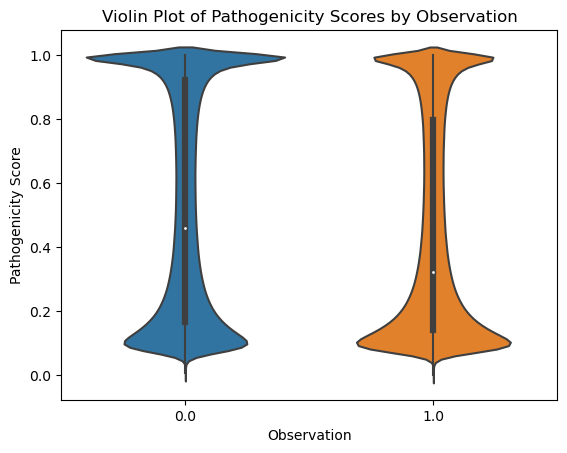

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'observation' column is binary (0 or 1)
sns.violinplot(x='observation', y='am_pathogenicity', data=merged_df)
plt.xlabel('Observation')
plt.ylabel('Pathogenicity Score')
plt.title('Violin Plot of Pathogenicity Scores by Observation')
plt.show()

In [6]:
X = merged_df[['am_pathogenicity', 'prob_0']]
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.3846228224010675
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248589
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0690e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.1380e+07
Time:                        22:13:13   Pearson chi2:                 1.76e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4110
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                

In [7]:
X = merged_df['am_pathogenicity']
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.00752481687874873
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7241e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4482e+07
Time:                        22:15:43   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01030
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
am_pathogenicity    

In [8]:
X = merged_df['prob_0']
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.2909505232400059
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2317e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.4635e+07
Time:                        22:18:50   Pearson chi2:                 1.82e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3299
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prob_0       -15.4917      0.015 

In [9]:
y = merged_df['observation']
X = sm.add_constant(np.ones_like(y))

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

-3.552713678800501e-15
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7372e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4743e+07
Time:                        22:20:43   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):         -5.107e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2030      0.

In [10]:
X = merged_df['prob_0']
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.38342064958303146
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0711e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.1422e+07
Time:                        22:24:19   Pearson chi2:                 1.75e+07
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4100
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0379      0.001

In [11]:
X = merged_df['am_pathogenicity']
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.008068397398393157
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7231e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4463e+07
Time:                        22:26:24   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01104
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              

In [12]:
X = merged_df[['am_pathogenicity', 'prob_0']]
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.3348727140994401
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1554e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.3109e+07
Time:                        22:29:46   Pearson chi2:                 1.80e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3692
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
am_pathogenicity     